In [23]:
import os
import pickle
import sys

import numpy as np
import pandas as pd
import seaborn as sns
# testing
from pandas.testing import assert_frame_equal
from tqdm import tqdm

import j_utils.munging as mg
from lendingclub.lc_utils import gen_datasets
from lendingclub import config

pd.options.display.max_columns = 999
pd.options.display.max_rows = 60
pd.options.display.max_seq_items = None

What are important metrics to me?
For the unified final number, some measure of "wealth/return/money"
metric = maxmimum money left after choosing (month by month) top n 
metric = default rate of all loans choosing (month by month) top n

graphs = pct defaulting of topn/chosen loans
graphs = that returns and default rates improve as we get more selective


For the more individual parts:
graph = Default classifier: Prec-Recall curve, AUC, f1-score? loss numbers during training?
metric
metric = return predictor: rmse, 

# Script

In [10]:
%load_ext autoreload
%autoreload 2

In [1]:
# %%writefile ../../lendingclub/modeling/10_evaluate.py
import os
import pickle
import json
import sys
from typing import List
import argparse

import numpy as np
import pandas as pd
import seaborn as sns
# testing
from pandas.testing import assert_frame_equal
from tqdm import tqdm

import j_utils.munging as mg
from lendingclub import config, utils
from lendingclub.lc_utils import gen_datasets

parser = argparse.ArgumentParser()
parser.add_argument('--model', '-m', help='specify model(s) to train')

if not len(sys.argv) > 1:
    model_n = 'baseline' # , 'A', 'B', 'C', 'D', 'E', 'F', 'G'

def get_topn_ret(model, eval_df, n, return_col='0.07'): 
    '''
    Picks loans and get returns based on maximizing model_score
    '''
    assert n <= 1
    assert n >= 0
    return eval_df.nlargest(int(round(len(eval_df)*n)), f'{model}_score')['0.07'].mean()

def get_topn_def_pct(model, eval_df, n): #, bootstrap=False
    '''
    get the def percents with the top_n
    '''
    assert n <= 1
    assert n >= 0
    n_pick = max(1,int(round(len(eval_df)*n)))
    return eval_df.nlargest(n_pick, f'{model}_score')['target_strict'].sum()/n_pick

def eval_model(model_n, test, bs_idx):#, verbose=True, top_n=.05
    top_ns = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    issue_d_gr = test.groupby('issue_d')
    # make dicts to hold results
    total_top_n_ret_d = {}
    total_top_n_def_d = {}
    mbm_top_n_ret_d = {}
    mbm_top_n_def_d = {}
    bsmbm_top_n_ret_d = {}
    bsmbm_top_n_def_d = {}
    
    for n in top_ns:
         # overall top_n from whole test population
        top_n_ret = get_topn_ret(model_n, test, n)
        top_n_def = get_topn_def_pct(model_n, test, n)
        
        # month by month over all of test loans
        temp_mbm = {}
        temp_mbm_def = {}
        for d, g in issue_d_gr:
            temp_mbm[d] = get_topn_ret(model_n, g, n)
            temp_mbm_def[d] = get_topn_def_pct(model_n, g, n)
            
        # get bsmbm
        temp_bsmbm = {}
        temp_bsmbm_def = {}
        for i, idx in enumerate(bs_idx):
            temp = {}
            temp_def = {}
            df = test.loc[idx]
            for d, g in df.groupby('issue_d'):
                temp[d] = get_topn_ret(model_n, g, n)
                temp_def[d] = get_topn_def_pct(model_n, g, n)
            temp_bsmbm[i] = temp
            temp_bsmbm_def[i] = temp_def
        
        
        bsmbm_top_n_ret_d[n] = temp_bsmbm
        bsmbm_top_n_def_d[n] = temp_bsmbm_def
        mbm_top_n_ret_d[n] = temp_mbm
        mbm_top_n_def_d[n] = temp_mbm_def
        total_top_n_ret_d[n] = top_n_ret
        total_top_n_def_d[n] = top_n_def
        
        print(bsmbm_top_n_ret_d)
        print(mbm_top_n_ret_d)

        
    # SAVING ________________________________________________________________    
    # named stuff is non-tracked by dvc
    with open(os.path.join(config.results_dir,'{0}_return.json'.format(model_n)), 'w') as f:
        json.dump(total_top_n_ret_d, f)
    with open(os.path.join(config.results_dir,'{0}_default_rate.json'.format(model_n)), 'w') as f:
        json.dump(total_top_n_def_d, f)
        
    # unnamed version track with dvc
    with open(os.path.join(config.results_dir,'return.json'), 'w') as f:
        json.dump(total_top_n_ret_d, f)
    with open(os.path.join(config.results_dir,'default_rate.json'), 'w') as f:
        json.dump(total_top_n_def_d, f)
    
    

# if results dir doesn't exist, make it
if not os.path.isdir(config.results_dir):
    os.makedirs(config.results_dir)

# load in datasets
test = pd.read_feather(os.path.join(config.data_dir, 'eval_loan_info_scored.fth'))
# load in train_test_ids.pkl
with open(os.path.join(config.data_dir, 'train_test_ids.pkl'), 'rb') as f:
    train_test_ids = pickle.load(f)
test = utils.cut_to_ids(test, train_test_ids['test'])
# load in bootstrap_test_ids.pkl
with open(os.path.join(config.data_dir, 'bootstrap_test_ids.pkl'), 'rb') as f:
    bootstrap_test_ids = pickle.load(f)

eval_model(model_n, test, bootstrap_test_ids)
    
    
    

NameError: name 'model_n' is not defined

In [33]:
pd.Series(bootstrap_test_ids[0]).value_counts()

16231086     5
50869658     4
78259484     4
96334919     4
10159325     4
            ..
93921442     1
1450920      1
23313321     1
102955948    1
41226240     1
Length: 767, dtype: int64

In [31]:
utils.cut_to_ids(scored, bootstrap_test_ids[0])

end_d    issue_d  maturity_paid  maturity_time  \
120   2010-11-01 2010-06-01       0.154703       1.000000   
131   2011-09-01 2010-07-01       1.000000       1.000000   
145   2012-11-01 2010-08-01       1.000000       1.000000   
165   2015-11-01 2010-11-01       1.000000       1.000000   
179   2016-01-01 2010-12-01       1.000000       1.000000   
...          ...        ...            ...            ...   
18223 2019-07-01 2019-01-01       0.027262       0.194444   
18285 2019-03-01 2019-02-01       1.000000       0.100000   
18404 2019-02-01 2019-01-01       1.000000       0.116667   
18887 2019-05-01 2019-03-01       1.000000       0.138889   
19498 2019-05-01 2019-05-01       1.000000       0.083333   

       maturity_time_stat_adj  maturity_paid_stat_adj  rem_to_be_paid  \
120                       1.0                     1.0    10818.726562   
131                       1.0                     1.0        0.000000   
145                       1.0                     1.0        0.000000   
165                       1.0                     1.0        0.000000   
179                       1.0                     1.0        0.000000   
...                       ...                     ...             ...   
18223                     1.0                     1.0    14962.964844   
18285                     1.0                     1.0        0.000000   
18404                     1.0                     1.0        0.000000   
18887                     1.0                     1.0        0.000000   
19498                     1.0                     1.0        0.000000   

       roi_simple  target_loose  target_strict  ...      0.27      0.28  \
120      0.282857             1              1  ... -0.835448 -0.836117   
131      1.177554             0              0  ... -0.082278 -0.090513   
145      1.278257             0              0  ... -0.165075 -0.177422   
165      1.627916             0              0  ... -0.111448 -0.128585   
179      1.285518             0              0  ... -0.298349 -0.311881   
...           ...           ...            ...  ...       ...       ...   
18223    0.032258             1              1  ... -0.967838 -0.967864   
18285    1.026046             0              0  ...  0.005738  0.004919   
18404    1.021179             0              0  ...  0.000280 -0.000534   
18887    1.059562             0              0  ...  0.015874  0.014254   
19498    1.001057             0              0  ... -0.020493 -0.021291   

           0.29       0.3      0.31      0.32      0.33      0.34      0.35  \
120   -0.836783 -0.837445 -0.838105 -0.838760 -0.839413 -0.840063 -0.840709   
131   -0.098659 -0.106718 -0.114691 -0.122579 -0.130383 -0.138104 -0.145742   
145   -0.189534 -0.201416 -0.213074 -0.224513 -0.235736 -0.246749 -0.257555   
165   -0.145222 -0.161379 -0.177070 -0.192313 -0.207123 -0.221514 -0.235502   
179   -0.325020 -0.337778 -0.350169 -0.362206 -0.373901 -0.385265 -0.396311   
...         ...       ...       ...       ...       ...       ...       ...   
18223 -0.967890 -0.967916 -0.967942 -0.967968 -0.967994 -0.968020 -0.968046   
18285  0.004101  0.003285  0.002470  0.001656  0.000844  0.000033 -0.000777   
18404 -0.001348 -0.002159 -0.002970 -0.003779 -0.004587 -0.005394 -0.006199   
18887  0.012637  0.011024  0.009415  0.007810  0.006209  0.004612  0.003019   
19498 -0.022087 -0.022882 -0.023676 -0.024468 -0.025260 -0.026049 -0.026838   

       baseline_score  
120          0.807440  
131          0.222108  
145          0.036887  
165          0.835302  
179          0.137521  
...               ...  
18223        0.852622  
18285        0.551974  
18404        0.055379  
18887        0.734310  
19498        0.418871  

[767 rows x 45 columns]

# Old Notebook

In [1]:
import os
import pickle
import sys
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
# testing
from pandas.testing import assert_frame_equal
from tqdm import tqdm

import j_utils.munging as mg
from lendingclub import config
from lendingclub.lc_utils import gen_datasets


def examine_topn_pct(colname, top_n):
    '''
    double check what this does
    '''
    for pct in top_n:
        print("{0} ________________________".format(pct))
        group = test_eval_loan_info[test_eval_loan_info[colname] <= pct]
        group['grade'].value_counts().plot(kind='bar', figsize=(15,6))
        plt.show()
        (group['loan_status'].value_counts()/len(group)).plot(kind='bar', figsize=(15,6))
        plt.show()
        group['0.07'].hist(bins=50, figsize=(15,6))
        plt.show()
        group['issue_d'].value_counts().plot(figsize=(15,6))
        plt.show()

def add_score_from_df(eval_loan_info, test):
    '''
    Adds scores to test (missing scores) from eval_loan_info (has scores)
    '''
    test = test.copy()
    test_ids = test['id'].values
    eval_loan_info = eval_loan_info.set_index('id')
    eval_loan_info = eval_loan_info.loc[test_ids]
    eval_loan_info = eval_loan_info.reset_index()
    for col in eval_loan_info:
        if 'score' in col:
            if col not in test:
                test[col] = eval_loan_info[col].values
    return test

def get_topn_ret(model, eval_df, n, return_col='0.07', bootstrap=False):
    '''
    Picks loans and get returns based on maximizing model_score
    '''
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    return eval_df.nlargest(int(round(len(eval_df)*n)), f'{model}_score')['0.07'].mean()

def get_topn_def_pct(model, eval_df, n, bootstrap=False):
    '''
    get the def percents with the top_n
    '''
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    n_pick = int(round(len(eval_df)*n))
    return eval_df.nlargest(n_pick, f'{model}_score')['target_strict'].sum()/n_pick


def plot_mbm(df, ylower=-0.15, yupper=0.15, xlims=None):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, group in df.T.groupby(level=0):
        ax = group.dropna(axis=1).T.plot(figsize=(16,6))
        ax.set_ylim(ylower, yupper)
        if xlims:
            ax.set_xlim(xlims)
        
def plot_bsmbm(df, ylower=-0.15, yupper=0.15, xlims=None, target = 'return'):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, grp in df.groupby(['topn']):
        plt.figure(figsize=(16,6))
        ax = sns.lineplot(x='month', y=target, hue = 'model', data=grp)    
        ax.set_ylim(ylower, yupper)
        ax.set_title('top {0} pct bootstrapped month-by-month'.format(n))
        ax.set_xlabel('')
        if xlims:
            ax.set_xlim(xlims)
        plt.xticks(rotation=50)
        plt.show() 

def make_comparison_dfs(models: List, top_n: List, bs_groups: List, issue_d_g: List, test_eval_loan_info):
    full = {}
    mbm = {}
    bsmbm = {}
    full_def = {}
    mbm_def = {}
    bsmbm_def = {}
    for n in tqdm(top_n):
        full_h = {}
        mbm_h = {}
        bsmbm_h = {}
        full_def_h = {}
        mbm_def_h = {}
        bsmbm_def_h = {}

        for model in models:
            # get overall top n%
            full_h[model] = get_topn_ret(model, test_eval_loan_info, n)
            full_def_h[model] = get_topn_def_pct(model, test_eval_loan_info, n)

            # get month by month
            temp_mbm = {}
            temp_mbm_def = {}
            for d, g in issue_d_g:
                temp_mbm[d] = get_topn_ret(model, g, n)
                temp_mbm_def[d] = get_topn_def_pct(model, g, n)
            mbm_h[model] = temp_mbm
            mbm_def_h[model] = temp_mbm_def

            # get bsmbm
            temp_bsmbm = {}
            temp_bsmbm_def = {}
            for i, grouper in enumerate(bs_groups):
                temp = {}
                temp_def = {}
                for d, g in grouper:
                    temp[d] = get_topn_ret(model, g, n)
                    temp_def[d] = get_topn_def_pct(model, g, n)
                temp_bsmbm[i] = temp
                temp_bsmbm_def[i] = temp_def
            bsmbm_h[model] = temp_bsmbm
            bsmbm_def_h[model] = temp_bsmbm_def

        n = str(n)
        full[n] = full_h
        mbm[n] = mbm_h
        bsmbm[n] = bsmbm_h
        full_def[n] = full_def_h
        mbm_def[n] = mbm_def_h
        bsmbm_def[n] = bsmbm_def_h
        
    #organize and reshape all dataframes
    # whole_topn
    whole_topn_df = pd.DataFrame(full)
    # whole_topn_def
    whole_topn_def_df = pd.DataFrame(full_def)
    # reshape mbm
    reshaped = {(n, model): values for n, innerdict in mbm.items() for model, values in innerdict.items()}
    mbm_topn_df = pd.DataFrame(reshaped)
    # reshape mbm_def
    reshaped = {(n, model): values for n, innerdict in mbm_def.items() for model, values in innerdict.items()}
    mbm_topn_def_df = pd.DataFrame(reshaped)
    # reshape bsmbm
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_df = pd.DataFrame(reshaped)
    bsmbm_topn_df = bsmbm_topn_df.unstack().to_frame()
    bsmbm_topn_df.columns = ['return']
    bsmbm_topn_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_df.reset_index(inplace=True)
    # reshape bsmbm_def
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm_def.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_def_df = pd.DataFrame(reshaped)
    bsmbm_topn_def_df = bsmbm_topn_def_df.unstack().to_frame()
    bsmbm_topn_def_df.columns = ['default_rate']
    bsmbm_topn_def_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_def_df.reset_index(inplace=True)
    return whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df

def bootstrap_testset_load_proc(dpath, fname, test_eval_loan_info):
    df = pd.read_feather(os.path.join(dpath, fname))
    df = add_score_from_df(test_eval_loan_info, df)
    return df.groupby('issue_d')

In [2]:
dpath = config.data_dir
test_eval_loan_info = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
test_eval_loan_info = add_score_from_df(eval_loan_info, test_eval_loan_info)

In [3]:
bootstrap_testsets = [
    'test_eval_loan_info_0_bootstrap.fth',
    'test_eval_loan_info_1_bootstrap.fth',
    'test_eval_loan_info_2_bootstrap.fth',
    'test_eval_loan_info_3_bootstrap.fth',
    'test_eval_loan_info_4_bootstrap.fth',
    'test_eval_loan_info_5_bootstrap.fth',
    'test_eval_loan_info_6_bootstrap.fth',
    'test_eval_loan_info_7_bootstrap.fth',
    'test_eval_loan_info_8_bootstrap.fth',
    'test_eval_loan_info_9_bootstrap.fth',
]

bootstrap_ts_d = {k: bootstrap_testset_load_proc(dpath, k, test_eval_loan_info) for k in bootstrap_testsets}

In [10]:
models = ['baseline', 'A', 'B', 'C', 'D', 'E', 'F', 'G',]# 'catboost_clf', 'catboost_regr']'catboost_clf_cbdp', 'catboost_regr_cbdp'] #
top_n = [round(.01 + (.01 * n), 2) for n in range(30)]
bs_groups = bootstrap_ts_d.values()
issue_d_g = test_eval_loan_info.groupby('issue_d')

In [11]:
whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df = make_comparison_dfs(models, top_n, bs_groups, issue_d_g, test_eval_loan_info)

100%|██████████| 30/30 [14:48<00:00, 29.62s/it]


In [ ]:
# load in previous
wtn_df = pd.read_csv(os.path.join(dpath, 'whole_topn_df.csv'), index_col=0, )
wtndef_df = pd.read_csv(os.path.join(dpath, 'whole_topn_def_df.csv'), index_col=0)
mbm_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_df.csv'), index_col=0, header=[0,1])
mbm_df.index = pd.to_datetime(mbm_df.index)
mbmdef_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'), index_col=0, header=[0,1])
mbmdef_df.index = pd.to_datetime(mbmdef_df.index)
bsmbm_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'), index_col=0, parse_dates=['month'])
bsmbm_df['topn'] = bsmbm_df['topn'].astype(str)

bsmbmdef_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'), index_col=0, parse_dates=['month'])
bsmbmdef_df['topn'] = bsmbmdef_df['topn'].astype(str)
# bsmbmdef_df['default_rate'] = bsmbmdef_df['return']
#bsmbmdef_df = bsmbmdef_df.drop('return', axis=1)

# concat new with loaded
wtn_df = pd.concat([whole_topn_df, wtn_df])
wtndef_df = pd.concat([whole_topn_def_df, wtndef_df])
mbm_df = pd.concat([mbm_topn_df, mbm_df], axis=1).sort_index(axis=1)
mbmdef_df = pd.concat([mbm_topn_def_df, mbmdef_df], axis=1).sort_index(axis=1)
bsmbm_df = pd.concat([bsmbm_topn_df, bsmbm_df])
bsmbmdef_df = pd.concat([bsmbm_topn_def_df, bsmbmdef_df])



In [13]:
# or if completely fresh
wtn_df, wtndef_df, mbm_df, mbmdef_df, bsmbm_df, bsmbmdef_df = whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df

In [27]:
# plots
chk_models = ['baseline', 'A', 'B', 'C', 'D', 'E']#['A', 'logistic_regr', 'catboost_clf', 'catboost_clf_cbdp', 'catboost_regr', 'catboost_regr_cbdp',]
idx = pd.IndexSlice
slicer = idx[:,chk_models]
topn_check = ['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08',
              '0.09', '0.10', '0.15', '0.20', '0.25', '0.30']

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Text(0, 0.5, '.07 discounted returns')

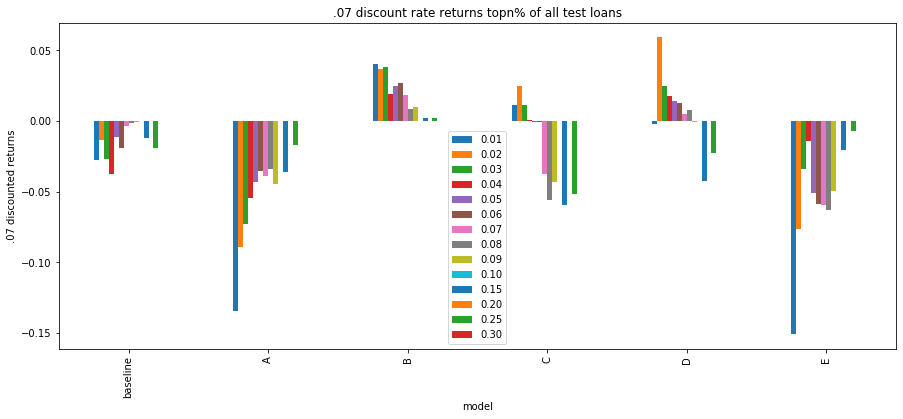

In [26]:
# whole_topn
ax = wtn_df.loc[chk_models, topn_check].plot(kind='bar', figsize=(15,6), title='.07 discount rate returns topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('.07 discounted returns')

Text(0, 0.5, 'percent target_strict of topn% picked')

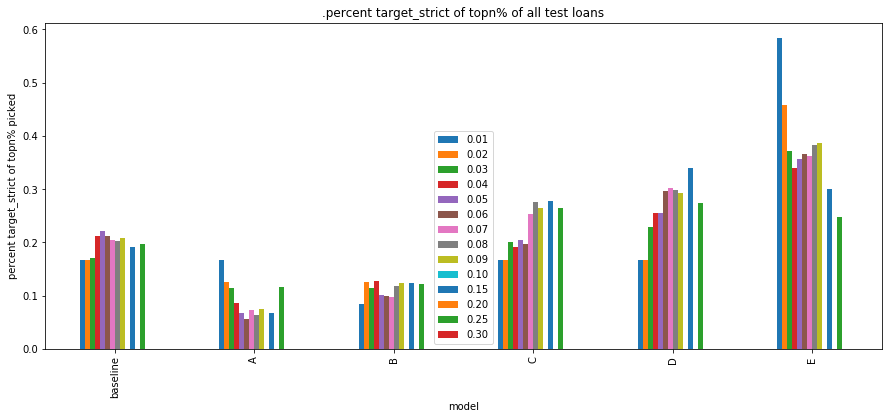

In [28]:
# whole_topn_def
ax = wtndef_df.loc[chk_models, topn_check].plot(kind='bar', figsize=(15,6), title='.percent target_strict of topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('percent target_strict of topn% picked')

In [41]:
multi_index = pd.MultiIndex.from_arrays([topn_check * len(chk_models), chk_models * len(topn_check)])

In [43]:
mbm_df.loc[:, slicer]

0.01                         0.02              ...      0.29  \
           baseline   A   B   C   D   E baseline   A   B   C  ...         B   
2010-06-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
2010-07-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
2010-08-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
2010-11-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
2010-12-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
...             ...  ..  ..  ..  ..  ..      ...  ..  ..  ..  ...       ...   
2018-12-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...  0.032066   
2019-01-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ... -0.000254   
2019-02-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   
2019-03-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...  0.034138   
2019-05-01      NaN NaN NaN NaN NaN NaN      NaN NaN NaN NaN  ...       NaN   

                                               0.3                      \
                   C         D         E  baseline         A         B   
2010-06-01       NaN       NaN       NaN       NaN       NaN       NaN   
2010-07-01       NaN       NaN       NaN       NaN       NaN       NaN   
2010-08-01       NaN       NaN       NaN       NaN       NaN       NaN   
2010-11-01       NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-01       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2018-12-01  0.025880  0.020520  0.020520  0.025880  0.020520  0.032066   
2019-01-01 -0.000254 -0.000254 -0.000254  0.010075  0.010075 -0.000254   
2019-02-01       NaN       NaN       NaN       NaN       NaN       NaN   
2019-03-01  0.034138  0.034138  0.034138  0.034138  0.034138  0.034138   
2019-05-01       NaN       NaN       NaN       NaN       NaN       NaN   

                                          
                   C         D         E  
2010-06-01       NaN       NaN       NaN  
2010-07-01       NaN       NaN       NaN  
2010-08-01       NaN       NaN       NaN  
2010-11-01       NaN       NaN       NaN  
2010-12-01       NaN       NaN       NaN  
...              ...       ...       ...  
2018-12-01  0.025880  0.020520  0.020520  
2019-01-01 -0.000254 -0.000254 -0.000254  
2019-02-01       NaN       NaN       NaN  
2019-03-01  0.034138  0.034138  0.034138  
2019-05-01       NaN       NaN       NaN  

[103 rows x 180 columns]

In [ ]:
# mbm_topn
plot_mbm(mbm_df.loc[:, slicer], )#xlims=xlims)

# notebook

In [17]:
import sys
import os
import pickle
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
from lendingclub.lc_utils import gen_datasets
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 60
pd.options.display.max_seq_items = None

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')

# testing
from pandas.testing import assert_frame_equal

for each model: 

Have one overall test set

1) compare topn% of all test in aggregate, look at %def of topn

2) compare month-by-month top30%, look at %def

From the test set make 10 bootstrap month by month test sets

3) compare bootstrap month-by-month top30%, look at %def

check that higher topn% (pickier) does produce better returns

In [4]:
def examine_topn_pct(colname, top_n):
    '''
    
    '''
    for pct in top_n:
        print("{0} ________________________".format(pct))
        group = test_eval_loan_info[test_eval_loan_info[colname] <= pct]
        group['grade'].value_counts().plot(kind='bar', figsize=(15,6))
        plt.show()
        (group['loan_status'].value_counts()/len(group)).plot(kind='bar', figsize=(15,6))
        plt.show()
        group['0.07'].hist(bins=50, figsize=(15,6))
        plt.show()
        group['issue_d'].value_counts().plot(figsize=(15,6))
        plt.show()

def add_score_from_df(eval_loan_info, test):
    '''
    Adds scores to test (missing scores) from eval_loan_info (has scores)
    '''
    test = test.copy()
    test_ids = test['id'].values
    eval_loan_info = eval_loan_info.set_index('id')
    eval_loan_info = eval_loan_info.loc[test_ids]
    eval_loan_info = eval_loan_info.reset_index()
    for col in eval_loan_info:
        if 'score' in col:
            if col not in test:
                test[col] = eval_loan_info[col].values
    return test

def get_topn_ret(model, eval_df, n, return_col='0.07', bootstrap=False):
    '''
    Picks loans and get returns based on maximizing model_score
    '''
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    return eval_df.nlargest(round(len(eval_df)*n), f'{model}_score')['0.07'].mean()

def get_topn_def_pct(model, eval_df, n, bootstrap=False):
    assert n <= 1
    assert n >= 0
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    n_pick = round(len(eval_df)*n)
    return eval_df.nlargest(n_pick, f'{model}_score')['target_strict'].sum()/n_pick

from typing import List

def plot_mbm(df, ylower=-0.15, yupper=0.15, xlims=None):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, group in df.T.groupby(level=0):
        ax = group.dropna(axis=1).T.plot(figsize=(16,6))
        ax.set_ylim(ylower, yupper)
        if xlims:
            ax.set_xlim(xlims)
        
def plot_bsmbm(df, ylower=-0.15, yupper=0.15, xlims=None, target = 'return'):
    '''
    xlims should be tuple of lower and upper (date)
    '''
    for n, grp in df.groupby(['topn']):
        plt.figure(figsize=(16,6))
        ax = sns.lineplot(x='month', y=target, hue = 'model', data=grp)    
        ax.set_ylim(ylower, yupper)
        ax.set_title('top {0} pct bootstrapped month-by-month'.format(n))
        ax.set_xlabel('')
        if xlims:
            ax.set_xlim(xlims)
        plt.xticks(rotation=50)
        plt.show() 

def make_comparison_dfs(models: List, top_n: List, bs_groups: List, issue_d_g: List, test_eval_loan_info):
    full = {}
    mbm = {}
    bsmbm = {}
    full_def = {}
    mbm_def = {}
    bsmbm_def = {}
    for n in tqdm(top_n):
        full_h = {}
        mbm_h = {}
        bsmbm_h = {}
        full_def_h = {}
        mbm_def_h = {}
        bsmbm_def_h = {}

        for model in models:
            # get overall top n%
            full_h[model] = get_topn_ret(model, test_eval_loan_info, n)
            full_def_h[model] = get_topn_def_pct(model, test_eval_loan_info, n)

            # get month by month
            temp_mbm = {}
            temp_mbm_def = {}
            for d, g in issue_d_g:
                temp_mbm[d] = get_topn_ret(model, g, n)
                temp_mbm_def[d] = get_topn_def_pct(model, g, n)
            mbm_h[model] = temp_mbm
            mbm_def_h[model] = temp_mbm_def

            # get bsmbm
            temp_bsmbm = {}
            temp_bsmbm_def = {}
            for i, grouper in enumerate(bs_groups):
                temp = {}
                temp_def = {}
                for d, g in grouper:
                    temp[d] = get_topn_ret(model, g, n)
                    temp_def[d] = get_topn_def_pct(model, g, n)
                temp_bsmbm[i] = temp
                temp_bsmbm_def[i] = temp_def
            bsmbm_h[model] = temp_bsmbm
            bsmbm_def_h[model] = temp_bsmbm_def

        n = str(n)
        full[n] = full_h
        mbm[n] = mbm_h
        bsmbm[n] = bsmbm_h
        full_def[n] = full_def_h
        mbm_def[n] = mbm_def_h
        bsmbm_def[n] = bsmbm_def_h
        
    # whole_topn
    whole_topn_df = pd.DataFrame(full)
    # whole_topn_def
    whole_topn_def_df = pd.DataFrame(full_def)
    # reshape mbm
    reshaped = {(n, model): values for n, innerdict in mbm.items() for model, values in innerdict.items()}
    mbm_topn_df = pd.DataFrame(reshaped)
    # reshape mbm_def
    reshaped = {(n, model): values for n, innerdict in mbm_def.items() for model, values in innerdict.items()}
    mbm_topn_def_df = pd.DataFrame(reshaped)
    # reshape bsmbm
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_df = pd.DataFrame(reshaped)
    bsmbm_topn_df = bsmbm_topn_df.unstack().to_frame()
    bsmbm_topn_df.columns = ['return']
    bsmbm_topn_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_df.reset_index(inplace=True)
    # reshape bsmbm_def
    reshaped = {(n, model, trial): values for n, innerdict in bsmbm_def.items() for model, subdict in innerdict.items() for trial, values in subdict.items()}
    bsmbm_topn_def_df = pd.DataFrame(reshaped)
    bsmbm_topn_def_df = bsmbm_topn_def_df.unstack().to_frame()
    bsmbm_topn_def_df.columns = ['default_rate']
    bsmbm_topn_def_df.index.names=['topn', 'model', 'trial', 'month']
    bsmbm_topn_def_df.reset_index(inplace=True)
    return whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df

In [19]:
test_eval_loan_info = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
test_eval_loan_info = add_score_from_df(eval_loan_info, test_eval_loan_info)

del eval_loan_info # to not confuse myself

# load bootstrapped datasets and setup
teli0 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_0_bootstrap.fth'))
teli0 = add_score_from_df(test_eval_loan_info, teli0)
idg0 = teli0.groupby('issue_d')

teli1 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_1_bootstrap.fth'))
teli1 = add_score_from_df(test_eval_loan_info, teli1)
idg1 = teli1.groupby('issue_d')

teli2 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_2_bootstrap.fth'))
teli2 = add_score_from_df(test_eval_loan_info, teli2)
idg2 = teli2.groupby('issue_d')

teli3 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_3_bootstrap.fth'))
teli3 = add_score_from_df(test_eval_loan_info, teli3)
idg3 = teli3.groupby('issue_d')

teli4 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_4_bootstrap.fth'))
teli4 = add_score_from_df(test_eval_loan_info, teli4)
idg4 = teli4.groupby('issue_d')

teli5 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_5_bootstrap.fth'))
teli5 = add_score_from_df(test_eval_loan_info, teli5)
idg5 = teli5.groupby('issue_d')

teli6 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_6_bootstrap.fth'))
teli6 = add_score_from_df(test_eval_loan_info, teli6)
idg6 = teli6.groupby('issue_d')

teli7 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_7_bootstrap.fth'))
teli7 = add_score_from_df(test_eval_loan_info, teli7)
idg7 = teli7.groupby('issue_d')

teli8 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_8_bootstrap.fth'))
teli8 = add_score_from_df(test_eval_loan_info, teli8)
idg8 = teli8.groupby('issue_d')

teli9 = pd.read_feather(os.path.join(dpath, 'test_eval_loan_info_9_bootstrap.fth'))
teli9 = add_score_from_df(test_eval_loan_info, teli9)
idg9 = teli9.groupby('issue_d')

# Create new dataframe to append/concat to saved ones

In [32]:
models = ['catboost_clf_cbdp', 'catboost_regr_cbdp'] #'A', 'B', 'C', 'D', 'E', 'F', 'G', 'catboost_clf', 'catboost_regr']
top_n = [.01, .02, .03, .05, .1, .15, .2, .3]
bs_groups = [idg0, idg1, idg2, idg3, idg4, idg5, idg6, idg7, idg8, idg9]
issue_d_g = test_eval_loan_info.groupby('issue_d')

In [33]:
whole_topn_df, whole_topn_def_df, mbm_topn_df, mbm_topn_def_df, bsmbm_topn_df, bsmbm_topn_def_df = make_comparison_dfs(models, top_n, bs_groups, issue_d_g, test_eval_loan_info)

100%|██████████| 8/8 [01:22<00:00, 10.37s/it]


# Load in previous for append/concat + analysis

In [34]:
wtn_df = pd.read_csv(os.path.join(dpath, 'whole_topn_df.csv'), index_col=0, )
wtndef_df = pd.read_csv(os.path.join(dpath, 'whole_topn_def_df.csv'), index_col=0)
mbm_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_df.csv'), index_col=0, header=[0,1])
mbm_df.index = pd.to_datetime(mbm_df.index)
mbmdef_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'), index_col=0, header=[0,1])
mbmdef_df.index = pd.to_datetime(mbmdef_df.index)
bsmbm_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'), index_col=0, parse_dates=['month'])
bsmbm_df['topn'] = bsmbm_df['topn'].astype(str)

bsmbmdef_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'), index_col=0, parse_dates=['month'])
bsmbmdef_df['topn'] = bsmbmdef_df['topn'].astype(str)
# bsmbmdef_df['default_rate'] = bsmbmdef_df['return']
#bsmbmdef_df = bsmbmdef_df.drop('return', axis=1)

In [35]:
wtn_df = pd.concat([whole_topn_df, wtn_df])
wtndef_df = pd.concat([whole_topn_def_df, wtndef_df])
mbm_df = pd.concat([mbm_topn_df, mbm_df], axis=1).sort_index(axis=1)
mbmdef_df = pd.concat([mbm_topn_def_df, mbmdef_df], axis=1).sort_index(axis=1)
bsmbm_df = pd.concat([bsmbm_topn_df, bsmbm_df])
bsmbmdef_df = pd.concat([bsmbm_topn_def_df, bsmbmdef_df])

In [36]:
# plots
chk_models = ['A', 'logistic_regr', 'catboost_clf', 'catboost_clf_cbdp', 'catboost_regr', 'catboost_regr_cbdp',]
idx = pd.IndexSlice
slicer = idx[:,chk_models]

Text(0, 0.5, '.07 discounted returns')

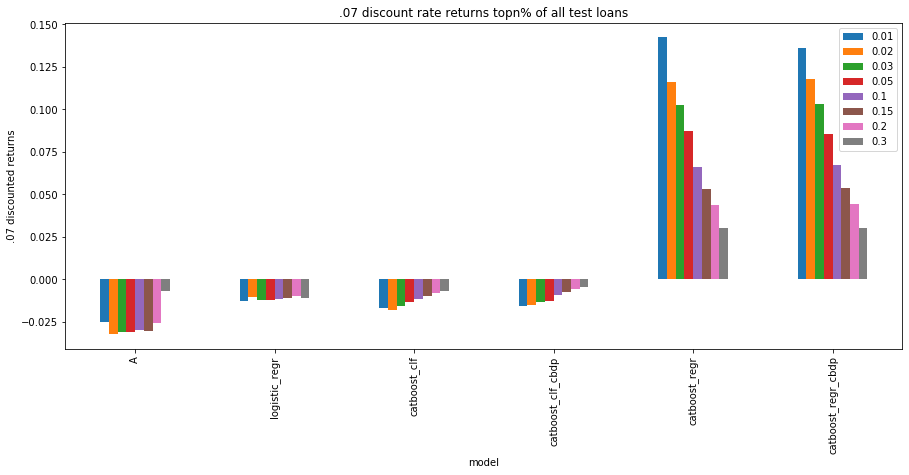

In [37]:
# whole_topn
ax = wtn_df.loc[chk_models].plot(kind='bar', figsize=(15,6), title='.07 discount rate returns topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('.07 discounted returns')

Text(0, 0.5, 'percent target_strict of topn% picked')

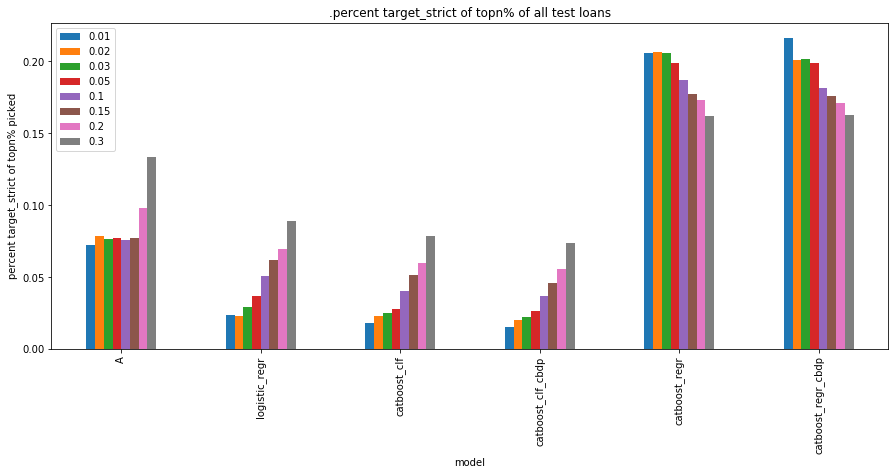

In [38]:
# whole_topn_def
ax = wtndef_df.loc[chk_models].plot(kind='bar', figsize=(15,6), title='.percent target_strict of topn% of all test loans')
ax.set_xlabel('model')
ax.set_ylabel('percent target_strict of topn% picked')

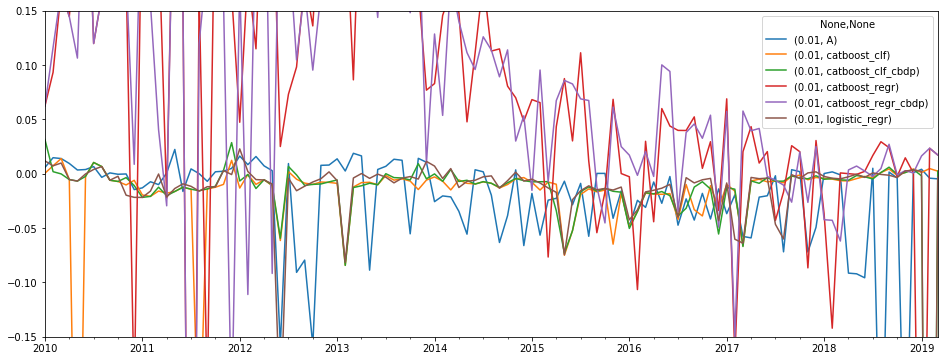

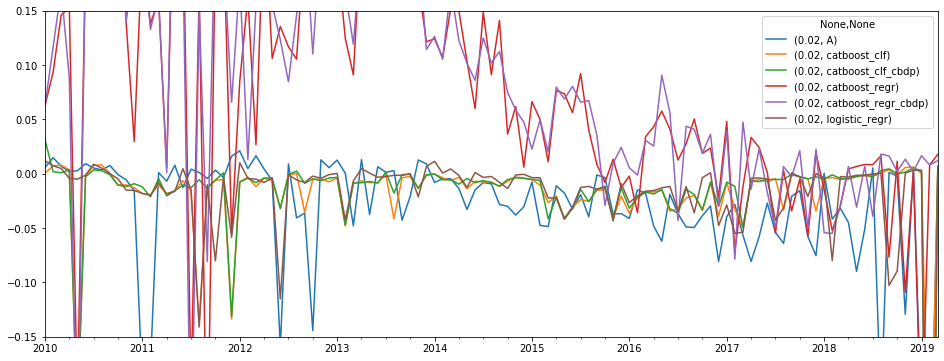

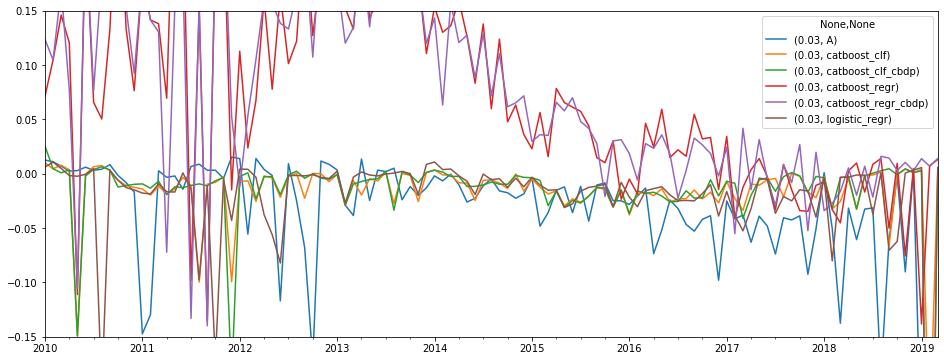

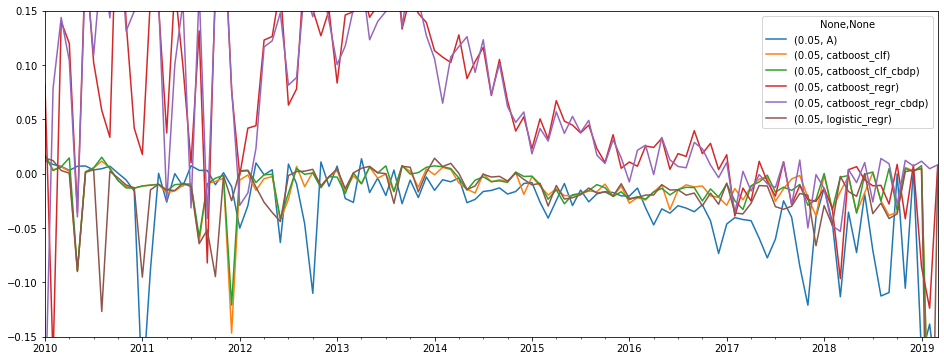

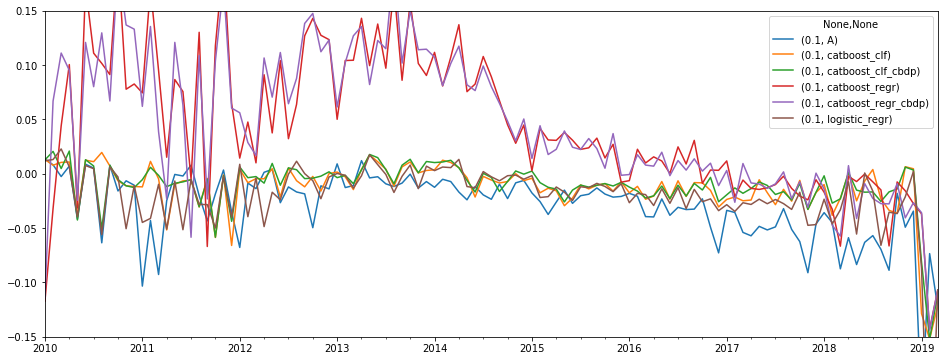

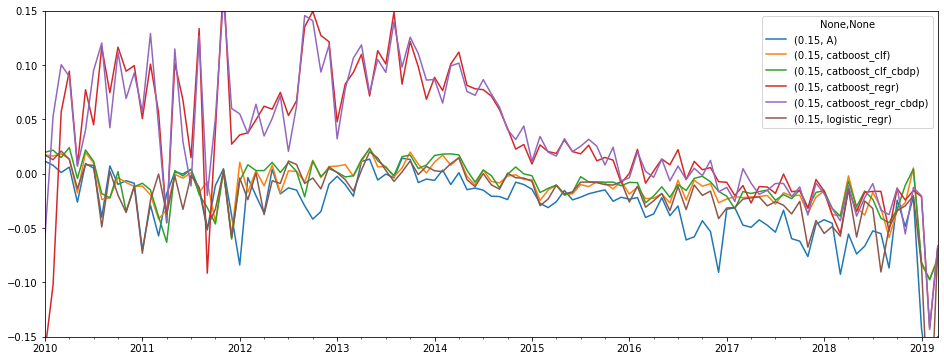

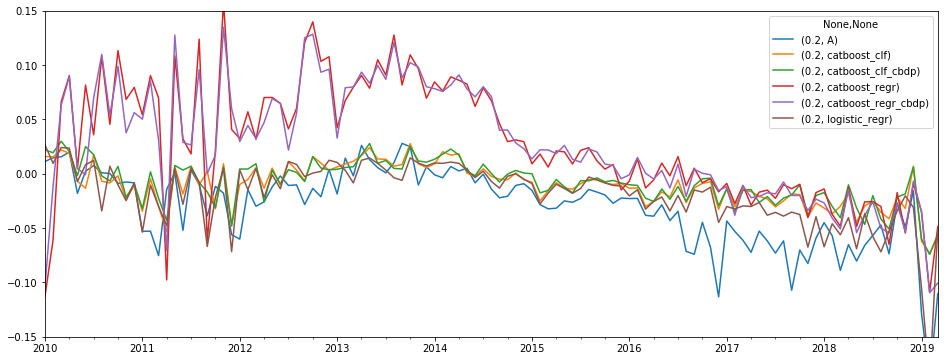

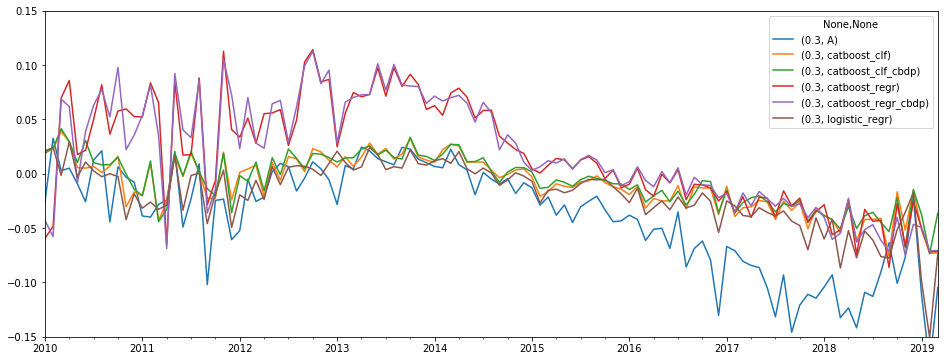

In [39]:
# mbm_topn
plot_mbm(mbm_df.loc[:, slicer], )#xlims=xlims)

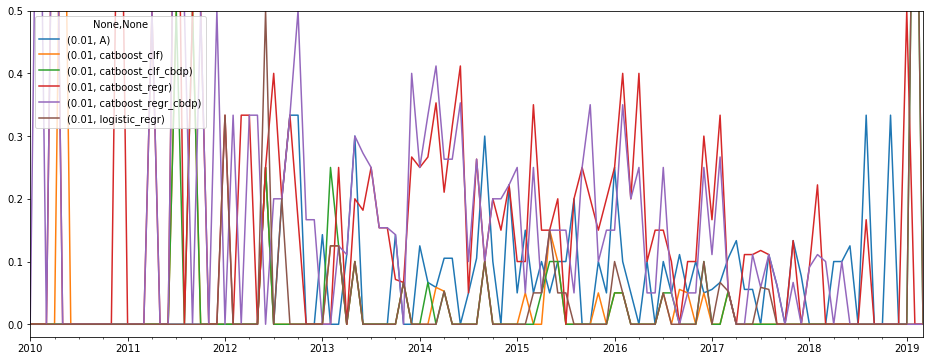

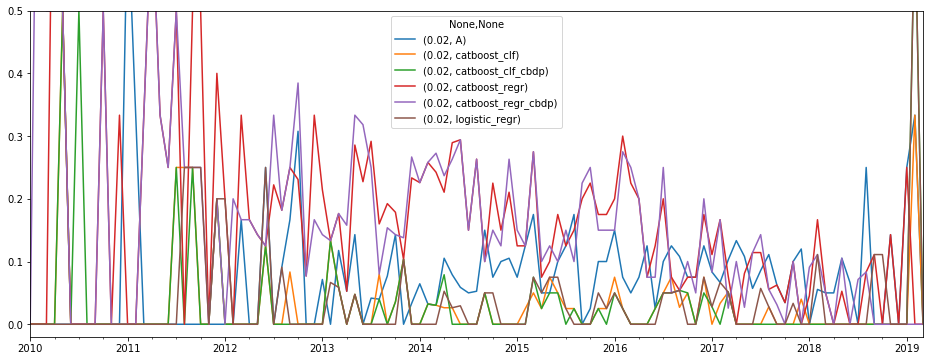

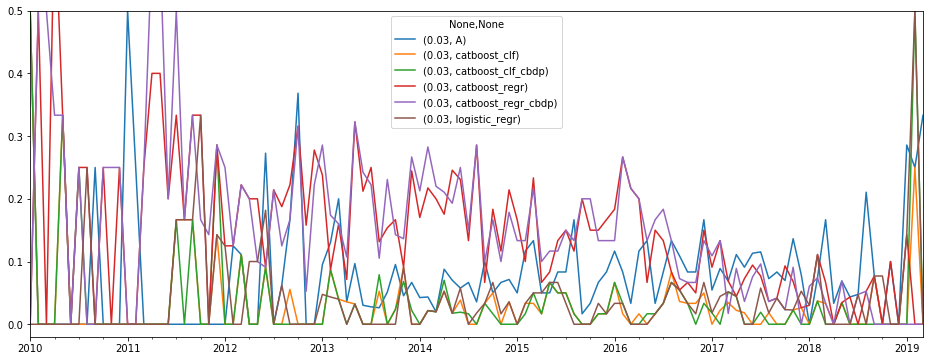

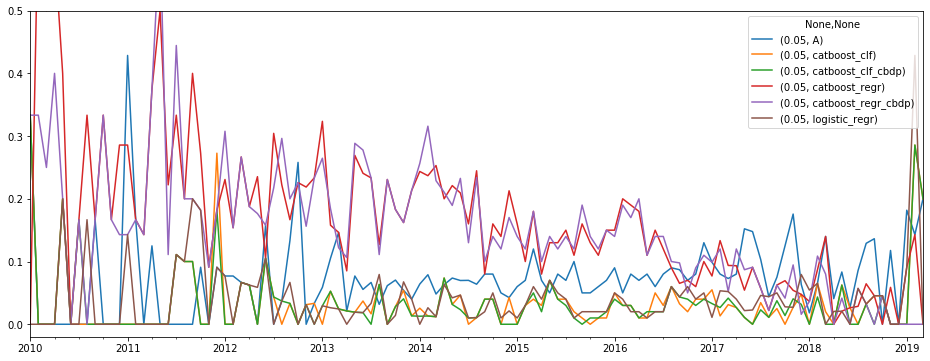

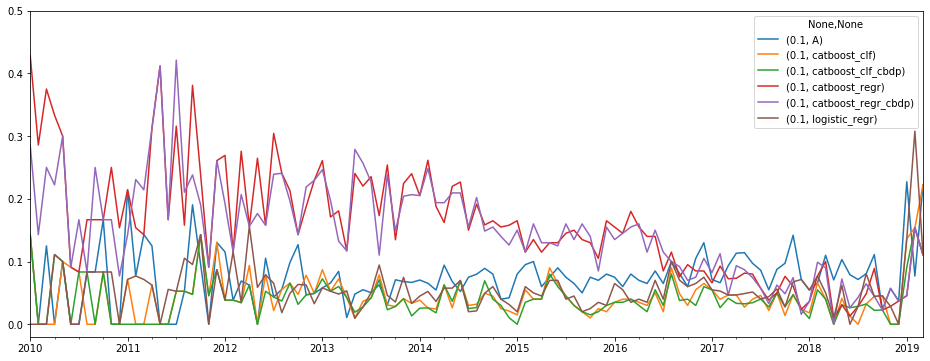

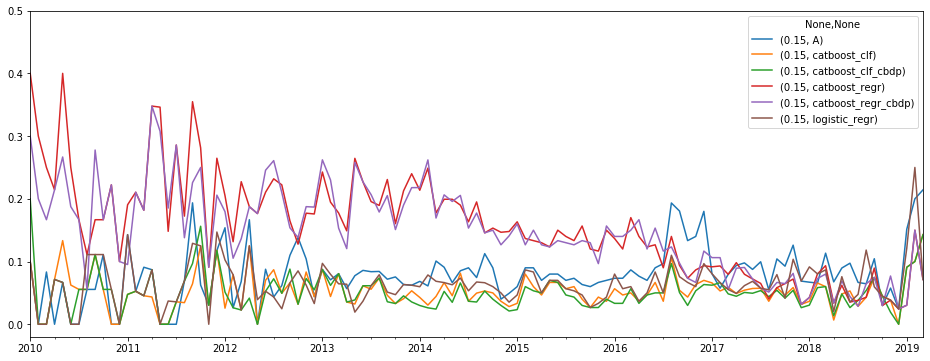

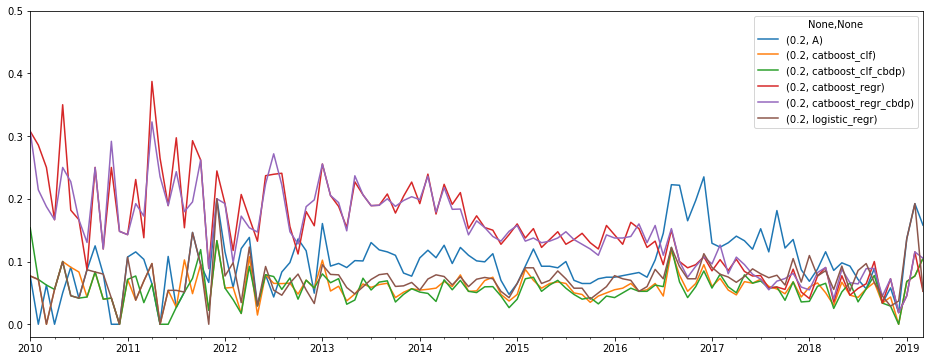

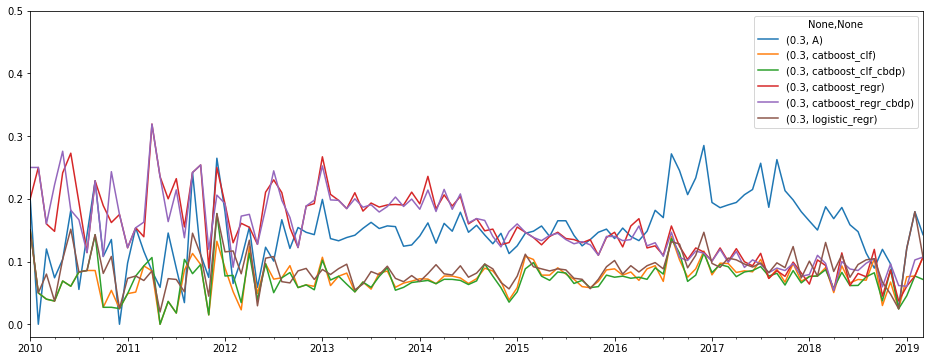

In [40]:
plot_mbm(mbmdef_df.loc[:, slicer], -0.02, .5, )

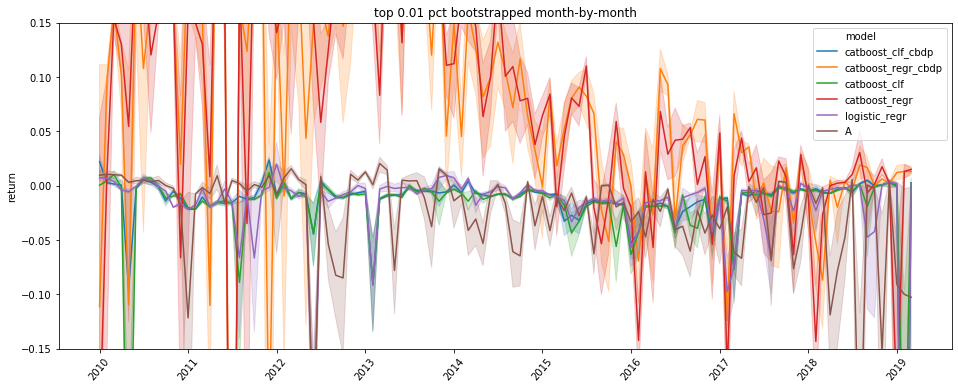

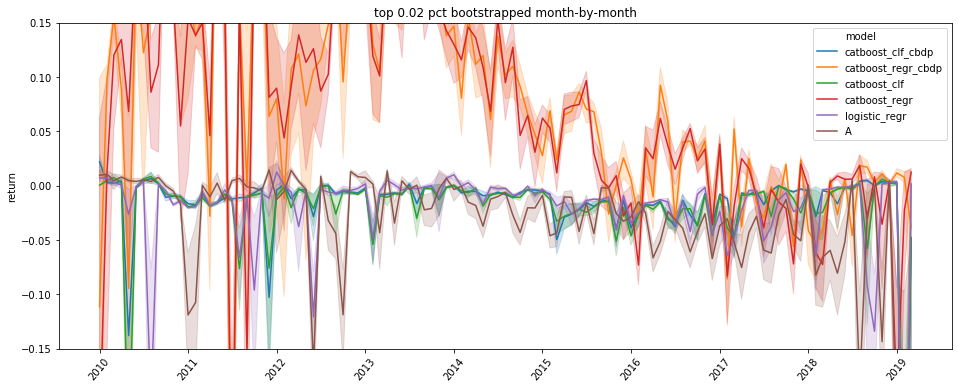

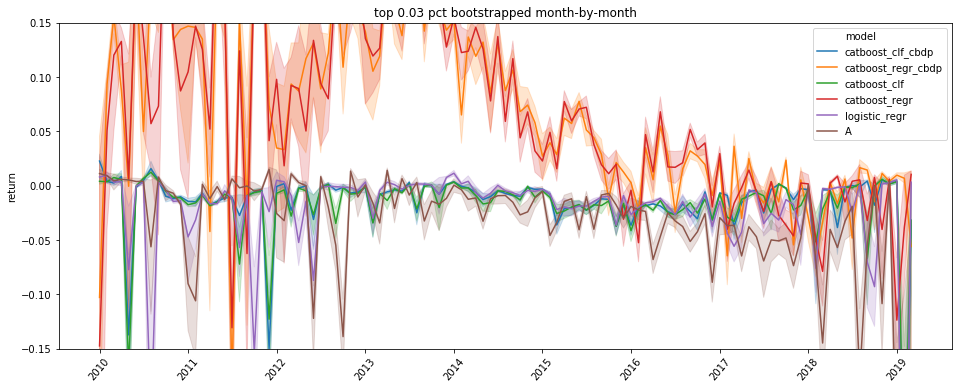

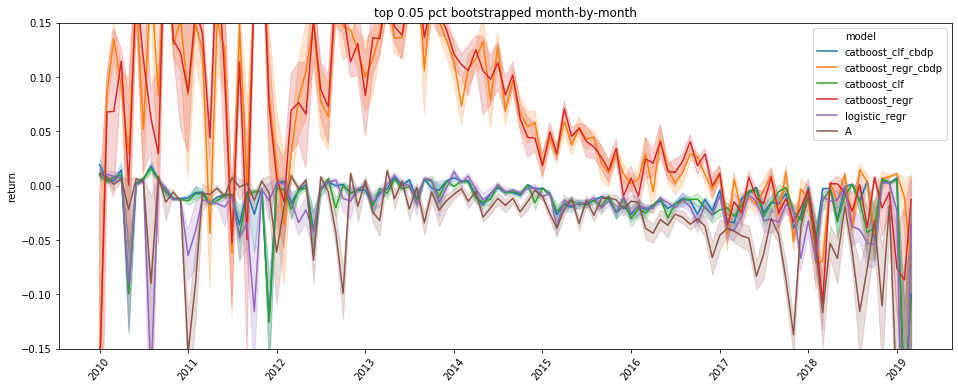

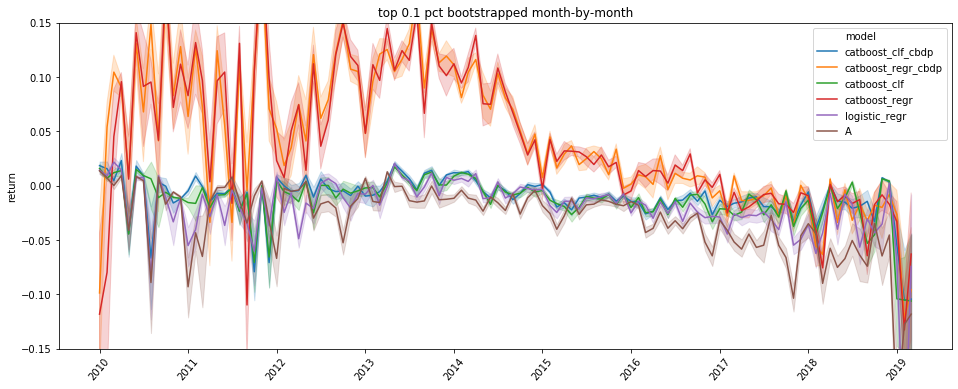

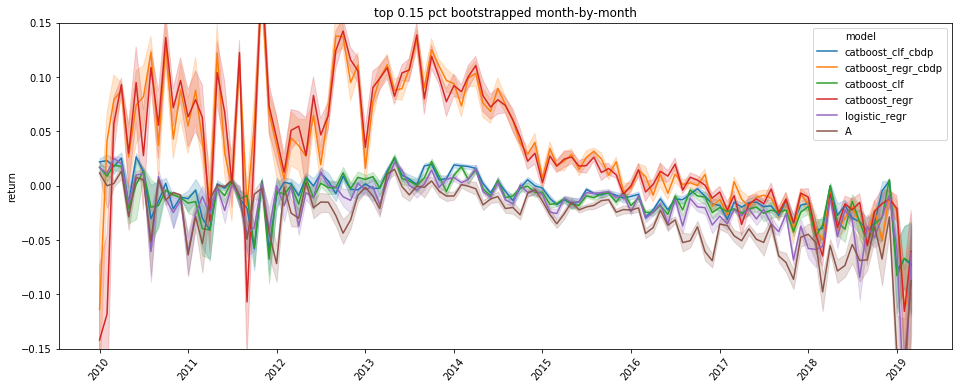

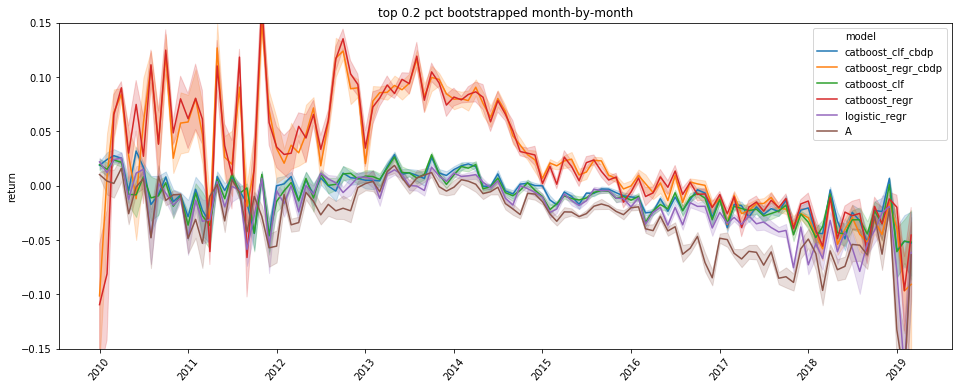

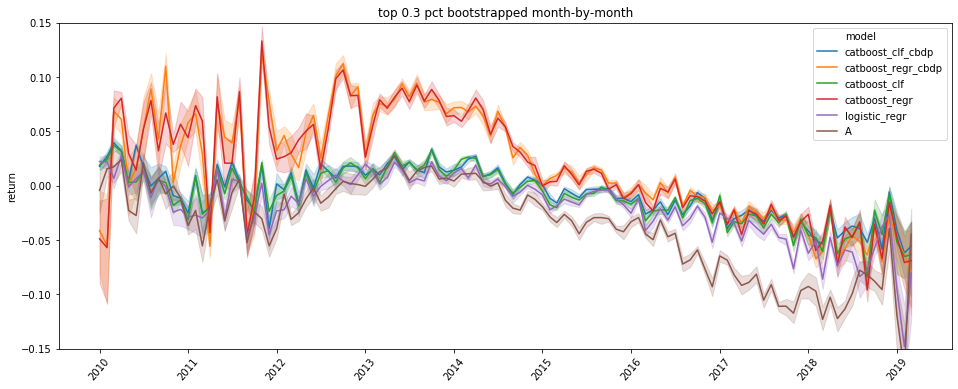

In [41]:
plot_bsmbm(bsmbm_df[bsmbm_df['model'].isin(chk_models)], )

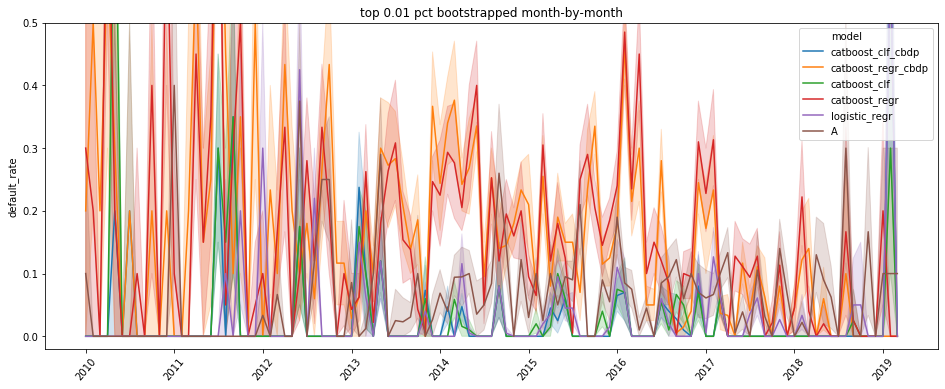

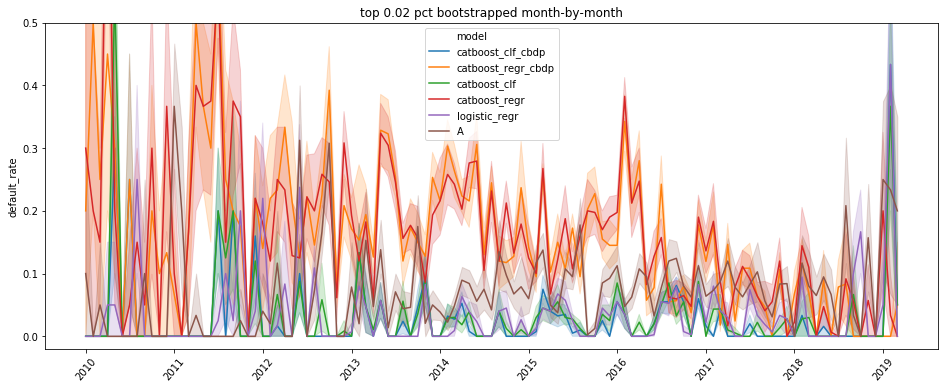

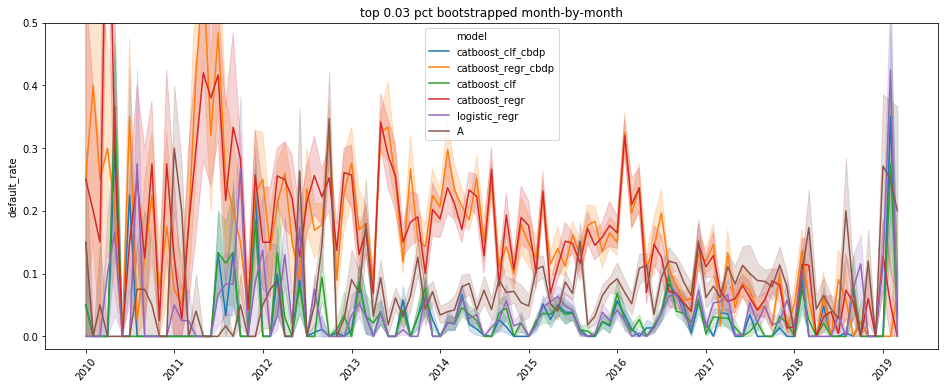

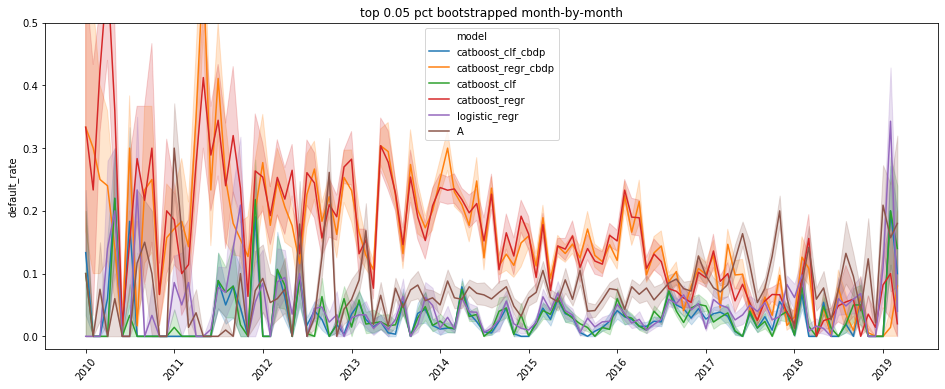

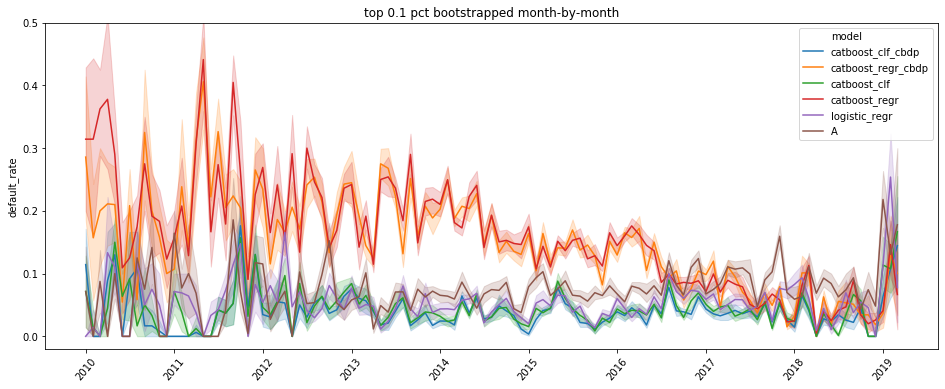

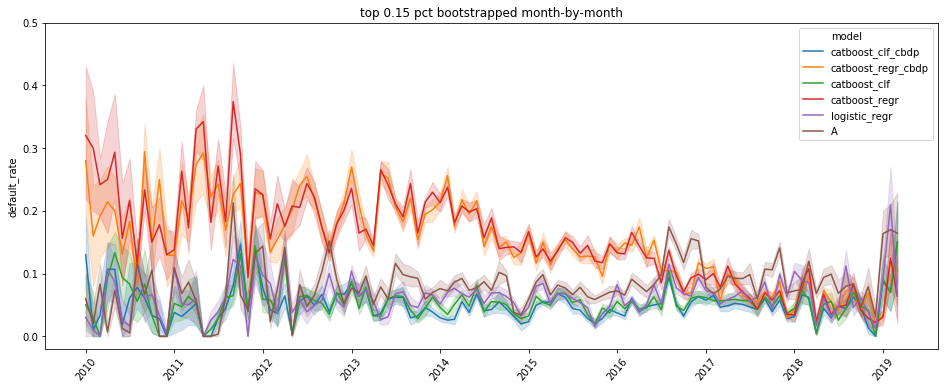

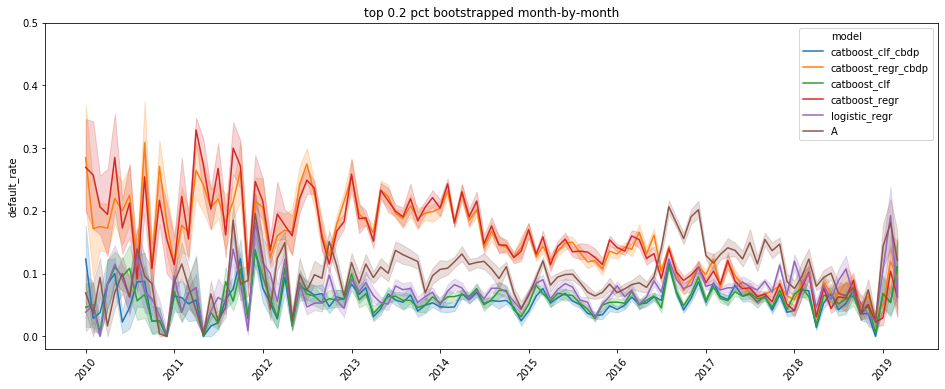

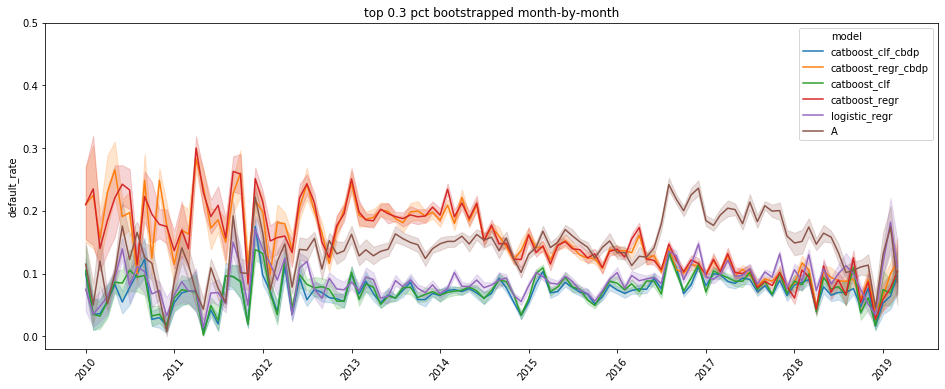

In [42]:
plot_bsmbm(bsmbmdef_df[bsmbmdef_df['model'].isin(chk_models)], -0.02, .5, target='default_rate')

# Deeper comparisons between interesting models

## catboost_clf

### looks better than logistic_regr on all accounts except .07% discounted return, where as percentiles expand, the return actually increases. Look into why this is

In [24]:
# hypothesis:
# the classifier is trained to detect defaulting loans, with no regard to return. Thus at top percentiles it
# ends up picking a lot of A loans as they are historically known to be safer. Once you move to include
# lower percentiles (down to top 30%), it ends up picking B/C/D loans and more often than not, picks correctly
# so returns are actually better once those paying higher interest rate loans are included
# How best to test?
# look at grade distribution per percentile for catboost_clf
test_eval_loan_info.head()

end_d    issue_d  maturity_paid  maturity_time  maturity_time_stat_adj  \
0 2011-06-01 2010-01-01       1.000000            1.0                     1.0   
1 2018-06-01 2015-06-01       1.000000            1.0                     1.0   
2 2017-03-01 2015-03-01       1.000000            1.0                     1.0   
3 2017-12-01 2016-04-01       1.000000            1.0                     1.0   
4 2013-02-01 2010-01-01       0.860756            1.0                     1.0   

   maturity_paid_stat_adj  rem_to_be_paid  roi_simple  target_loose  \
0                     1.0        0.000000    1.176152             0   
1                     1.0        0.000000    1.107802             0   
2                     1.0        0.000000    1.240191             0   
3                     1.0        0.000000    1.173879             0   
4                     1.0     1756.907104    0.969691             1   

   target_strict  loan_status      id grade  int_rate  term      0.05  \
0              0         paid   62499     D    0.1600    36  0.117222   
1              0         paid   65419     A    0.0689    36  0.028200   
2              0         paid   67586     D    0.1655    36  0.162119   
3              0         paid  347674     C    0.1367    36  0.111196   
4              1  charged_off  367030     A    0.0788    36 -0.091639   

       0.06      0.07      0.08      0.09       0.1      0.11      0.12  \
0  0.105880  0.094681  0.083623  0.072704  0.061922  0.051275  0.040762   
1  0.013168 -0.001562 -0.015994 -0.030137 -0.043997 -0.057580 -0.070893   
2  0.146950  0.132040  0.117384  0.102977  0.088814  0.074890  0.061202   
3  0.098906  0.086792  0.074852  0.063083  0.051483  0.040047  0.028775   
4 -0.103351 -0.114854 -0.126151 -0.137248 -0.148149 -0.158857 -0.169377   

       0.13      0.14      0.15      0.16      0.17      0.18      0.19  \
0  0.030380  0.020128  0.010004  0.000006 -0.009868 -0.019619 -0.029249   
1 -0.083943 -0.096735 -0.109275 -0.121569 -0.133623 -0.145442 -0.157032   
2  0.047745  0.034513  0.021504  0.008712 -0.003866 -0.016235 -0.028398   
3  0.017663  0.006709 -0.004090 -0.014737 -0.025233 -0.035581 -0.045783   
4 -0.179712 -0.189866 -0.199843 -0.209647 -0.219280 -0.228747 -0.238051   

        0.2      0.21      0.22      0.23      0.24      0.25      0.26  \
0 -0.038760 -0.048153 -0.057431 -0.066594 -0.075644 -0.084583 -0.093412   
1 -0.168397 -0.179544 -0.190476 -0.201199 -0.211717 -0.222035 -0.232158   
2 -0.040359 -0.052123 -0.063692 -0.075070 -0.086262 -0.097270 -0.108098   
3 -0.055842 -0.065760 -0.075539 -0.085182 -0.094690 -0.104065 -0.113311   
4 -0.247196 -0.256183 -0.265017 -0.273701 -0.282238 -0.290630 -0.298880   

       0.27      0.28      0.29       0.3      0.31      0.32      0.33  \
0 -0.102133 -0.110747 -0.119256 -0.127661 -0.135963 -0.144165 -0.152267   
1 -0.242090 -0.251834 -0.261396 -0.270780 -0.279989 -0.289027 -0.297897   
2 -0.118749 -0.129227 -0.139534 -0.149675 -0.159651 -0.169467 -0.179124   
3 -0.122428 -0.131418 -0.140285 -0.149029 -0.157652 -0.166157 -0.174545   
4 -0.306992 -0.314968 -0.322810 -0.330522 -0.338106 -0.345565 -0.352900   

       0.34      0.35  baseline_score   A_score  B_score   C_score   D_score  \
0 -0.160270 -0.168177        0.015095  0.000000      0.0  0.000000  0.099422   
1 -0.306605 -0.315153        0.983453  0.663344      0.0  0.000000  0.000000   
2 -0.188627 -0.197977        0.000001  0.000000      0.0  0.000000  0.246984   
3 -0.182819 -0.190979        0.673359  0.000000      0.0  0.994823  0.000000   
4 -0.360115 -0.367212        0.324803  0.216861      0.0  0.000000  0.000000   

   E_score  F_score  G_score  logistic_regr_score  catboost_clf_score  
0      0.0      0.0      0.0             0.379225            0.597550  
1      0.0      0.0      0.0             0.849572            0.941486  
2      0.0      0.0      0.0             0.460559            0.652070  
3      0.0      0.0      0.0             0.563201            0.699818  
4      0.

In [118]:
test_eval_loan_info['pctl_catboost_clf'] = pd.qcut(test_eval_loan_info['catboost_clf_score'], 100, labels = range(100, 0, -1)).astype(int)/100

0.01 ________________________


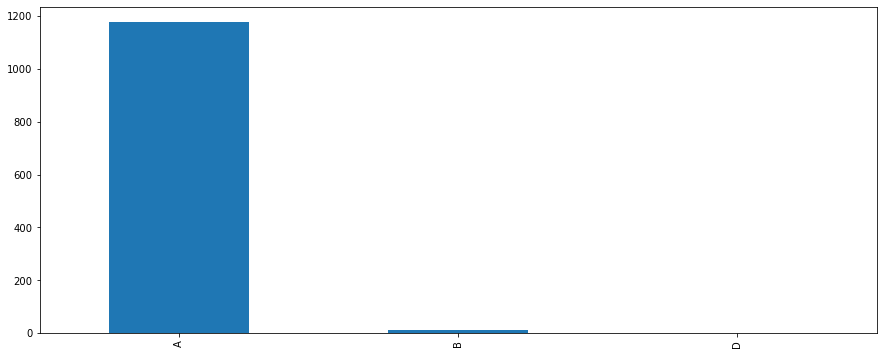

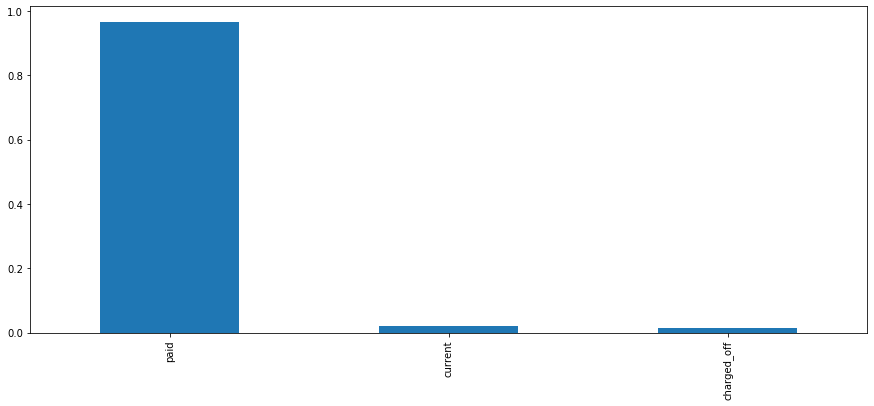

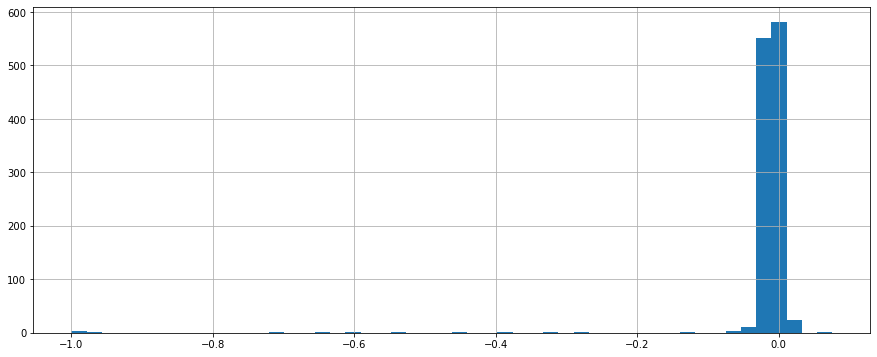

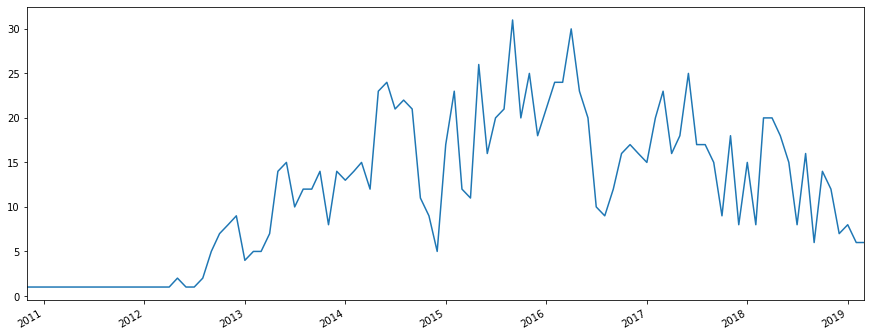

0.02 ________________________


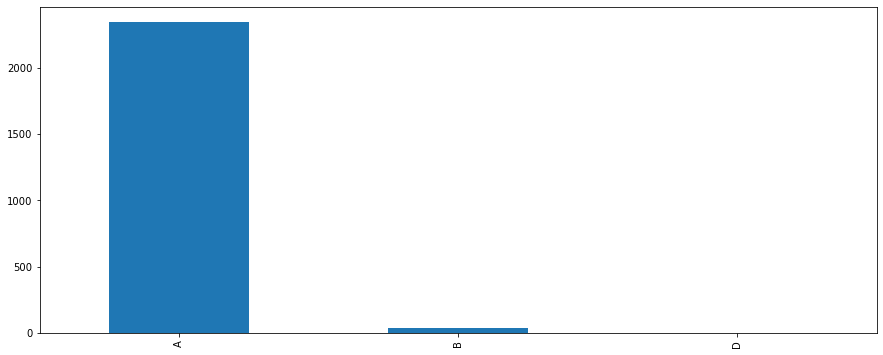

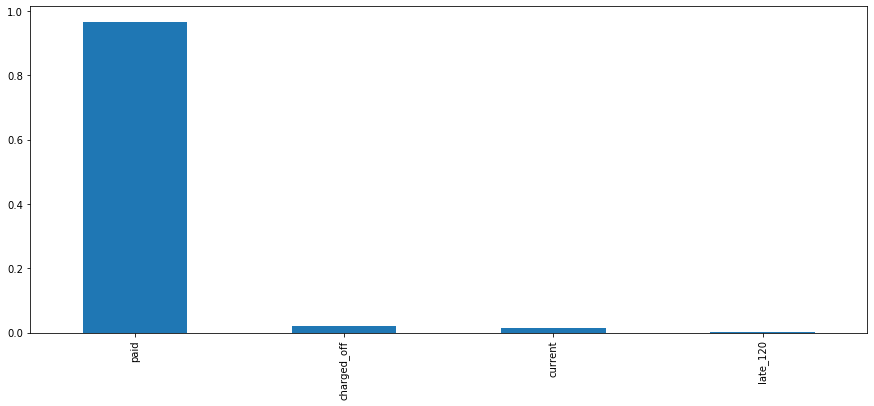

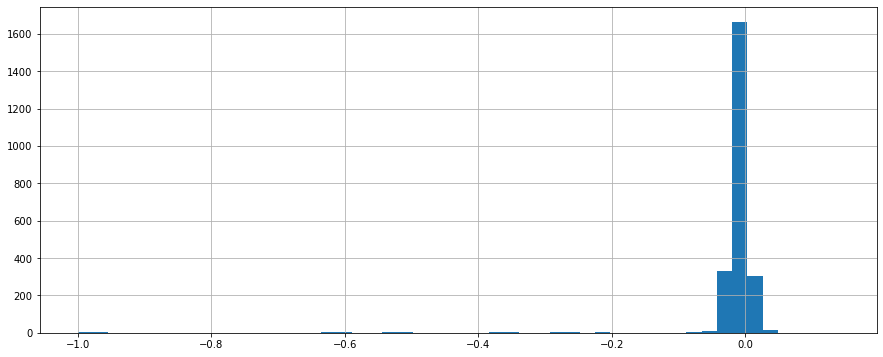

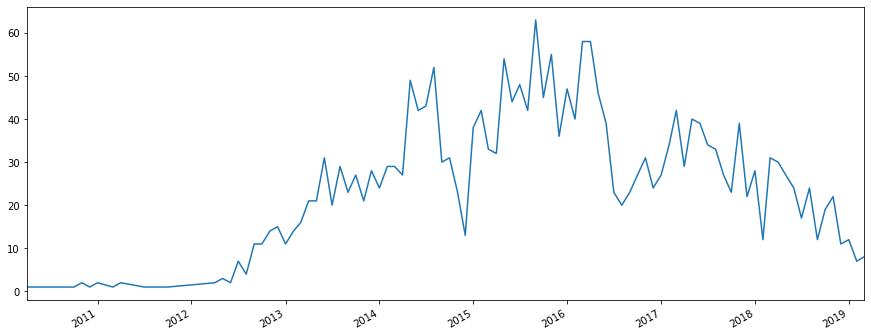

0.03 ________________________


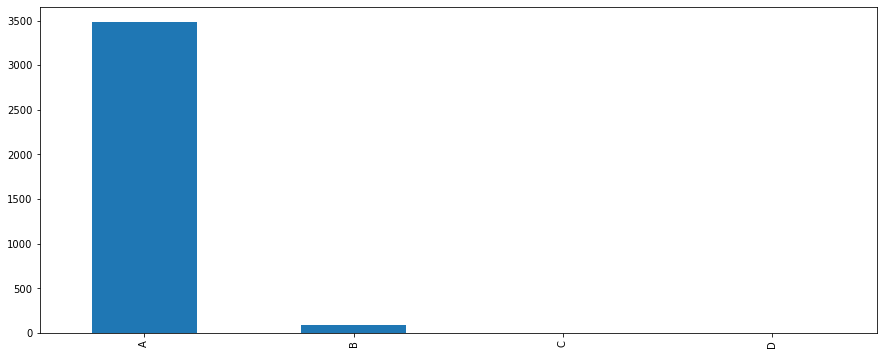

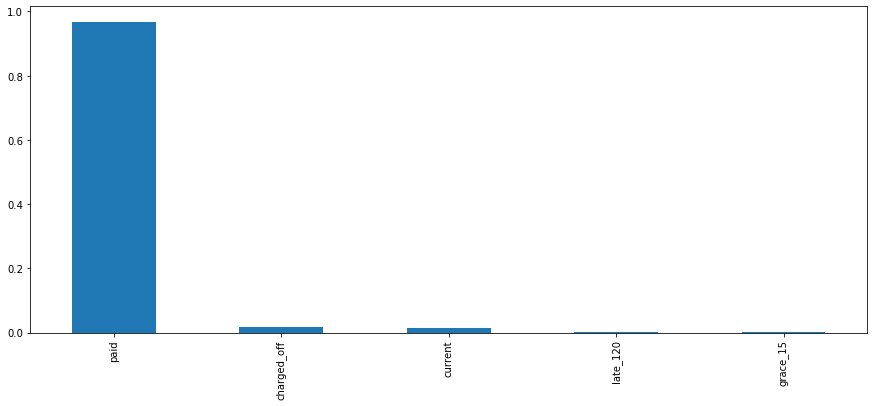

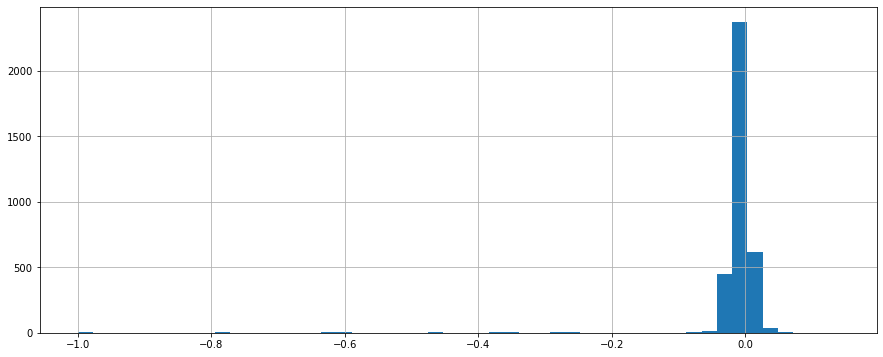

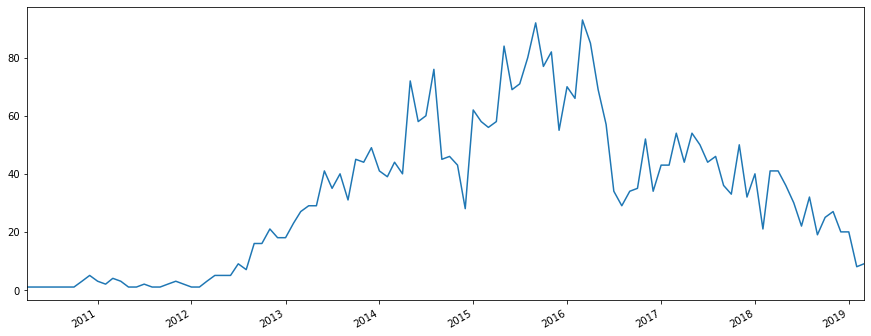

0.05 ________________________


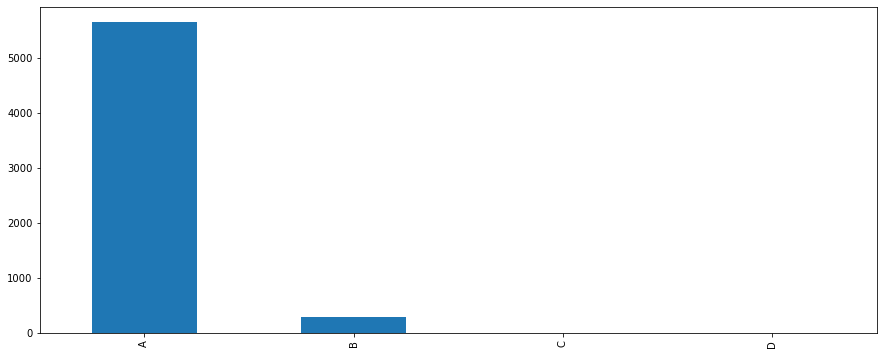

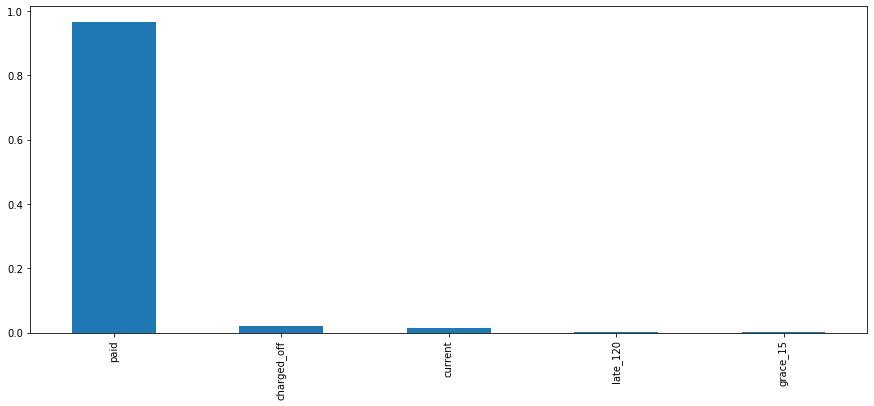

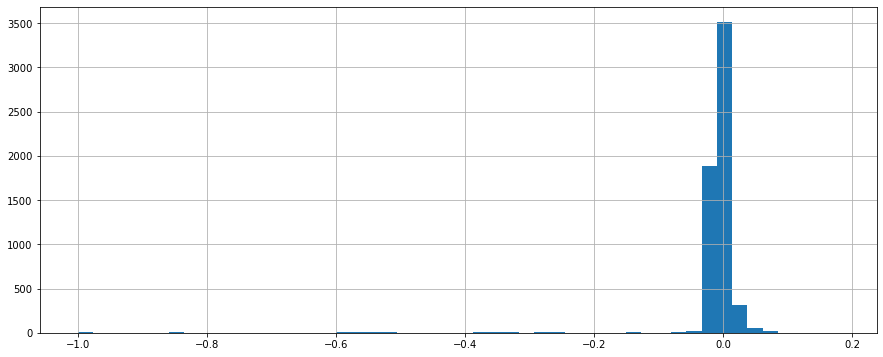

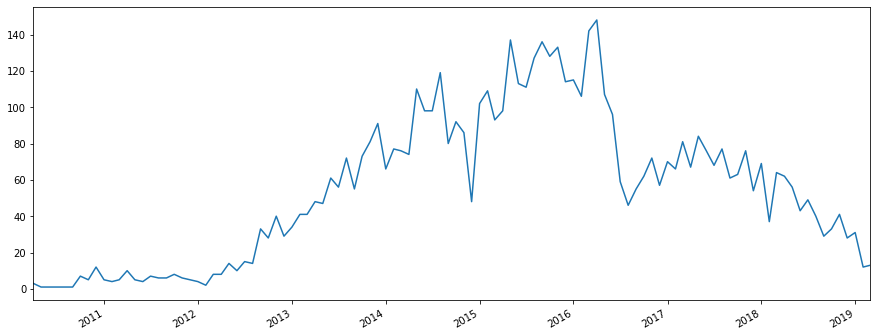

0.1 ________________________


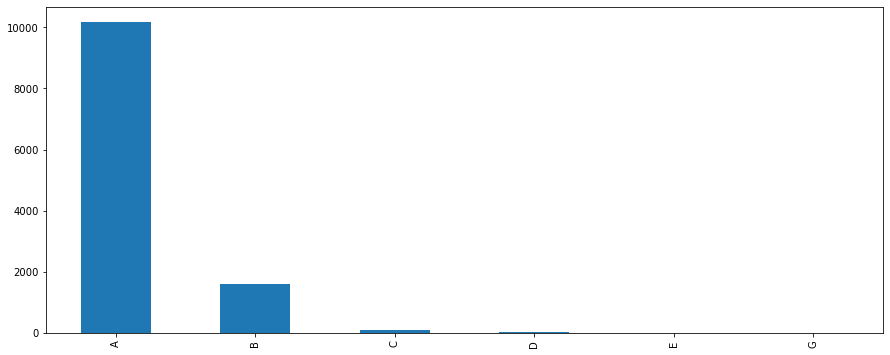

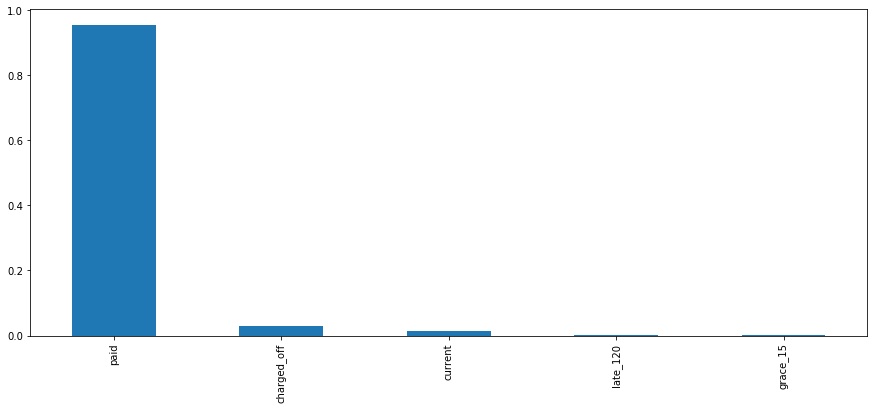

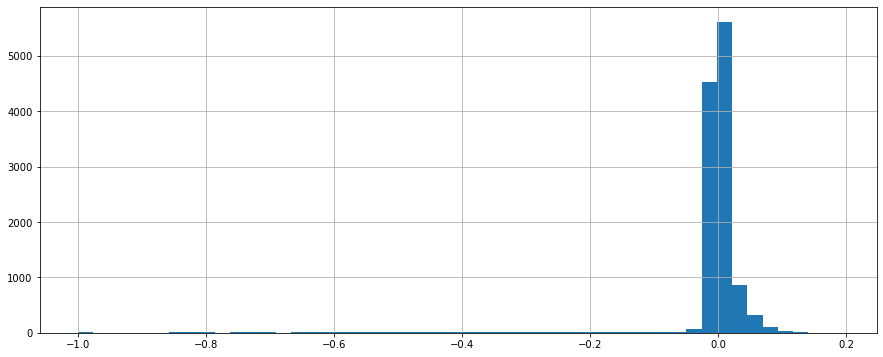

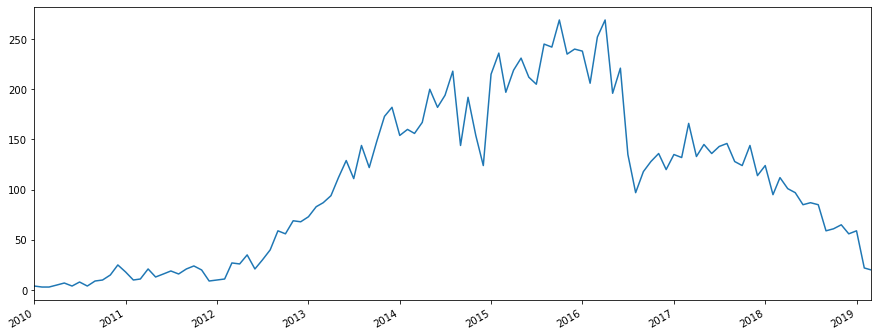

0.15 ________________________


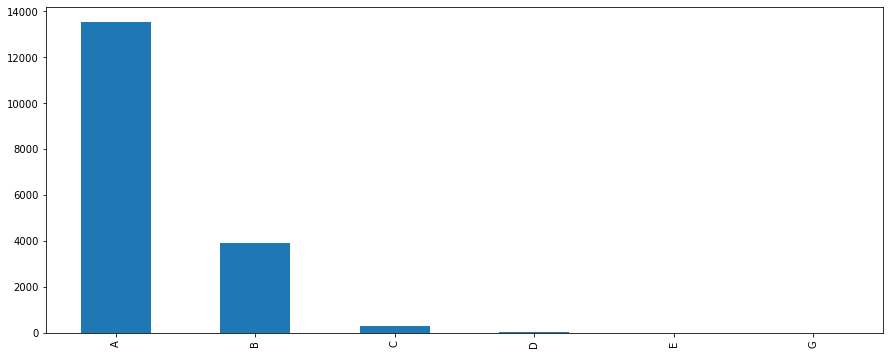

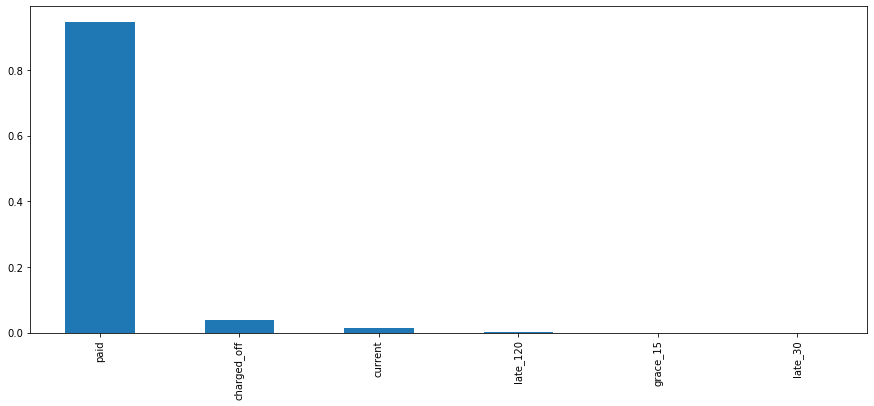

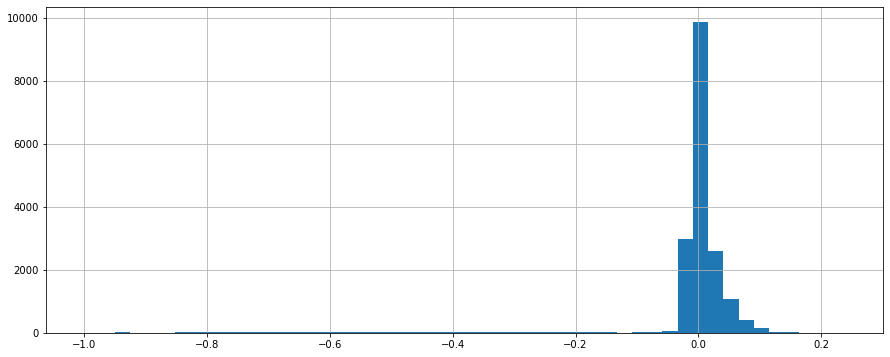

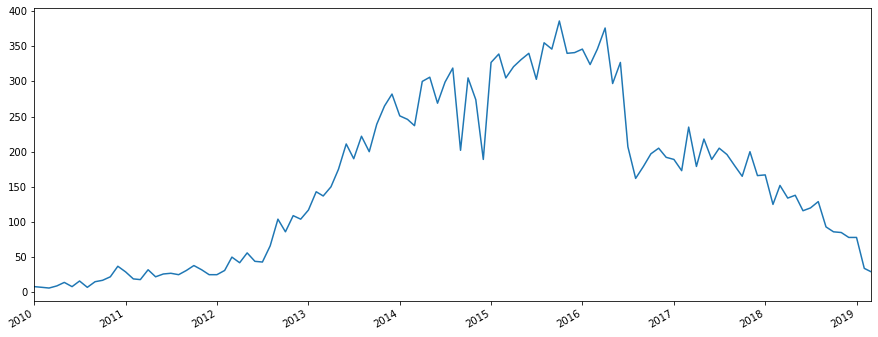

0.2 ________________________


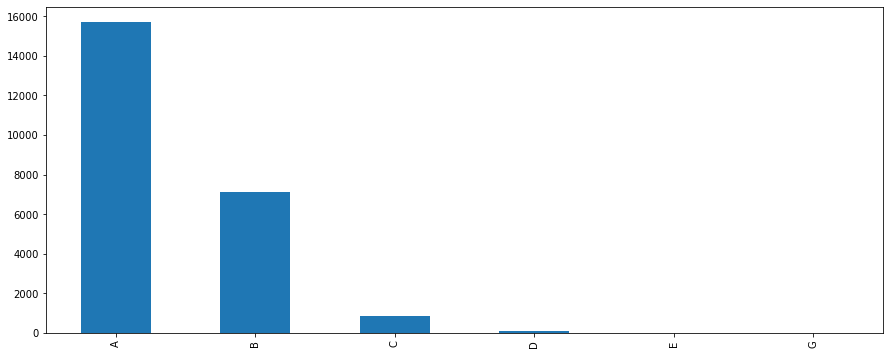

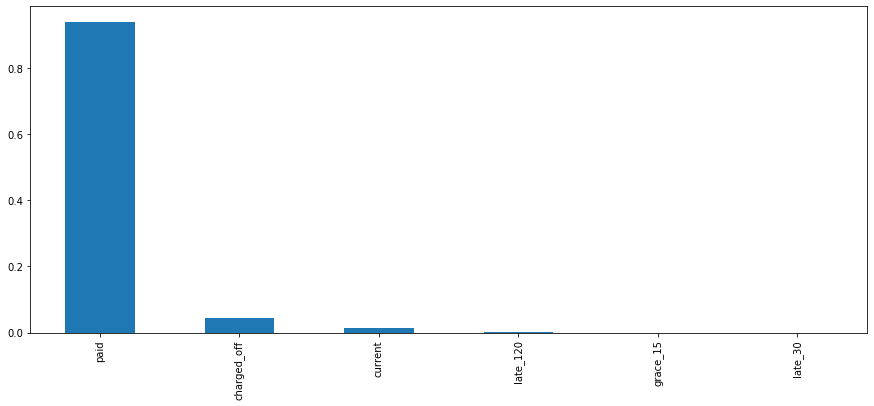

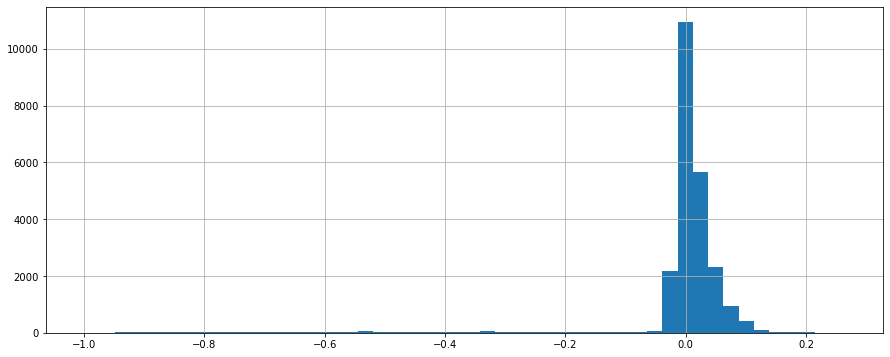

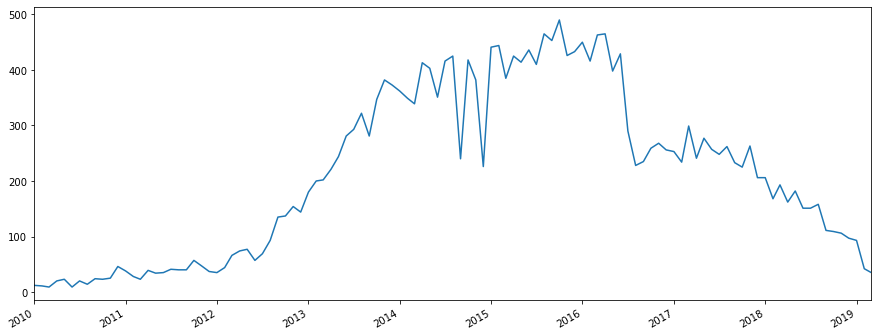

0.3 ________________________


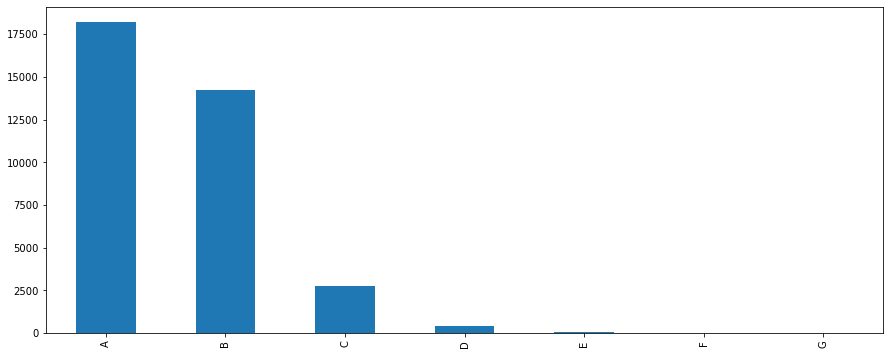

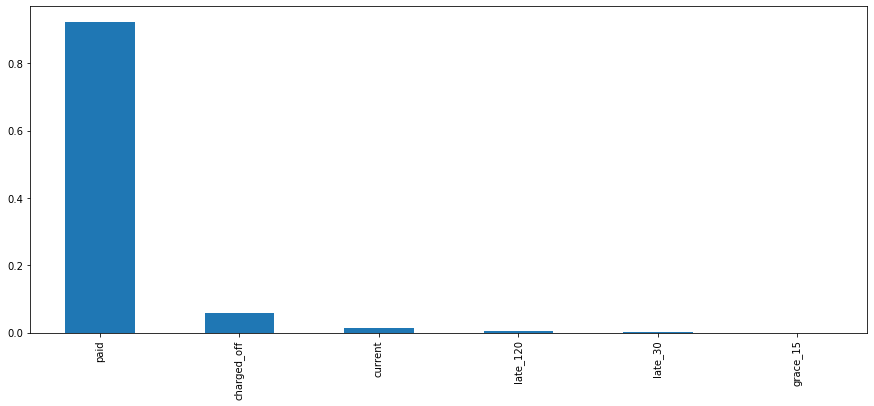

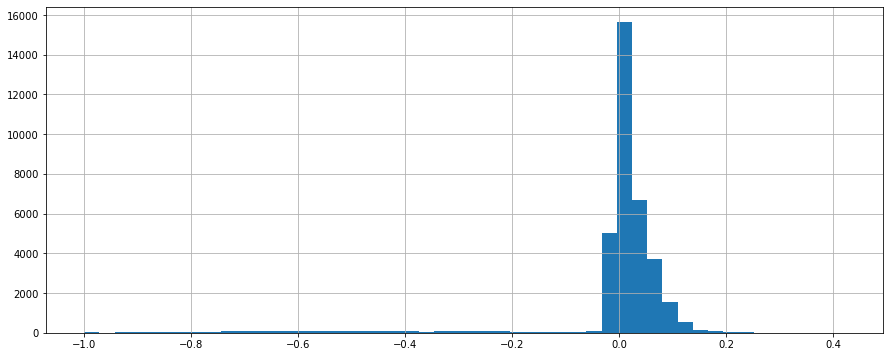

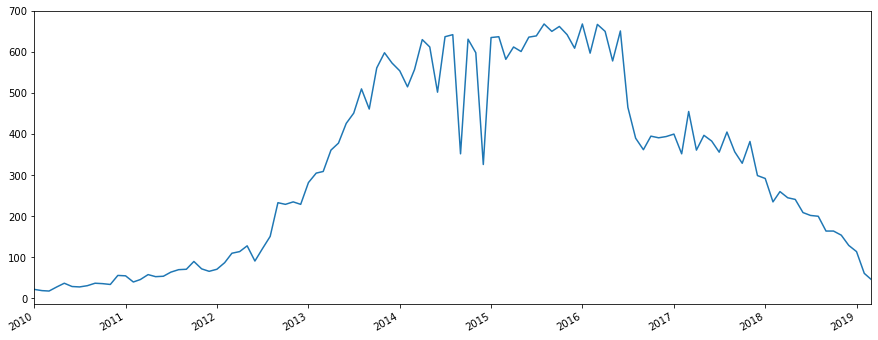

In [122]:
examine_topn_pct('pctl_catboost_clf', top_n)

## catboost_regr

### returns look stellar compared to every other model, but I want to verify that things are actually okay in the top 1% picked when it has a target_strict rate of about .2 (it COULD be picking loans that go late but actually do pay out in the end... investigate)

In [90]:
test_eval_loan_info['pctl_catboost_regr'] = pd.qcut(test_eval_loan_info['catboost_regr_score'], 100, labels = range(100, 0, -1)).astype(int)/100

0.01 ________________________


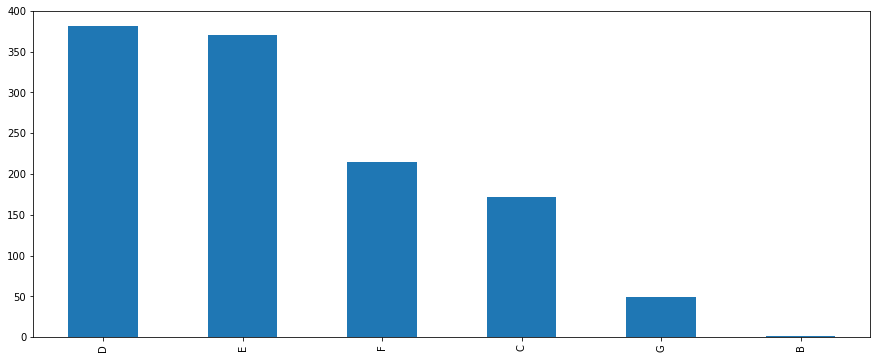

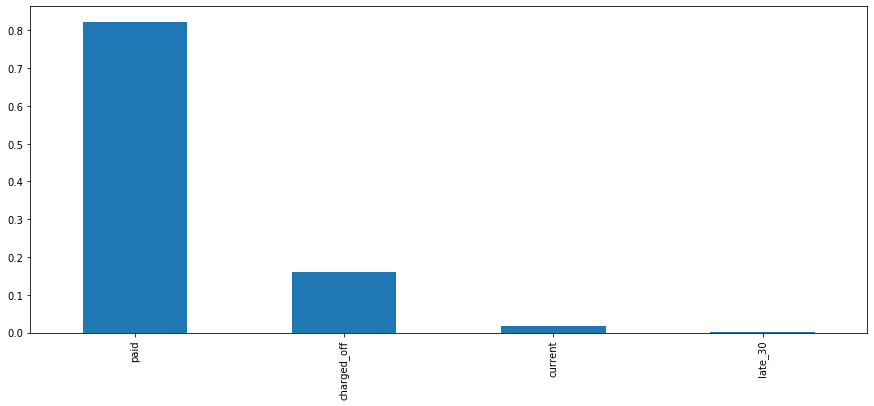

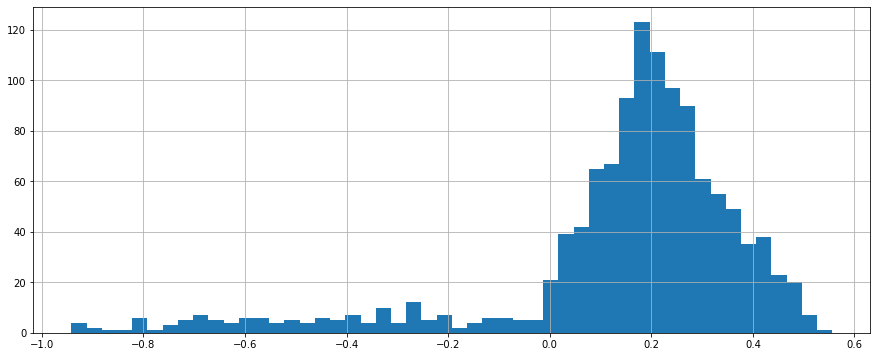

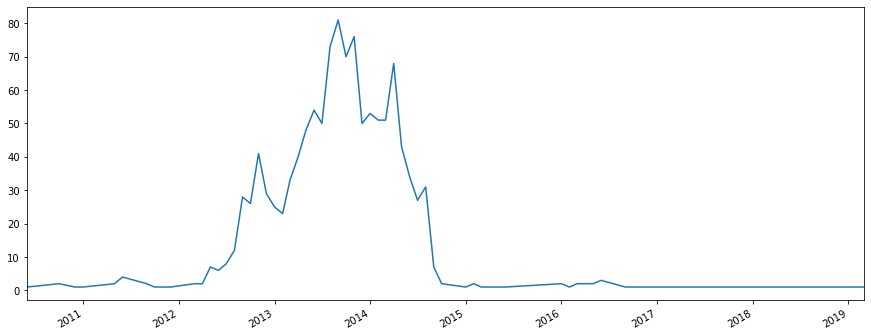

0.02 ________________________


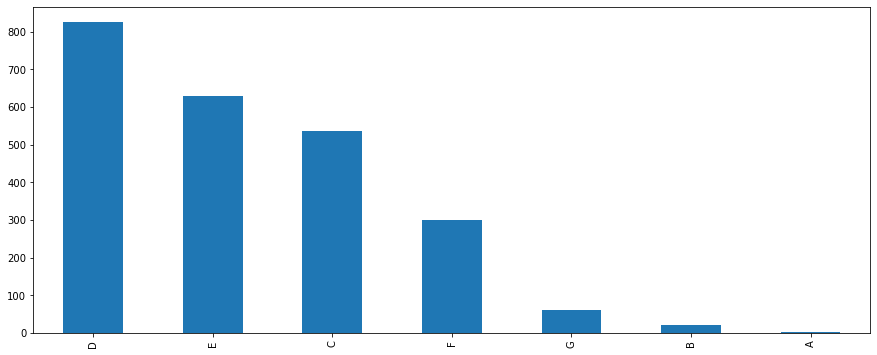

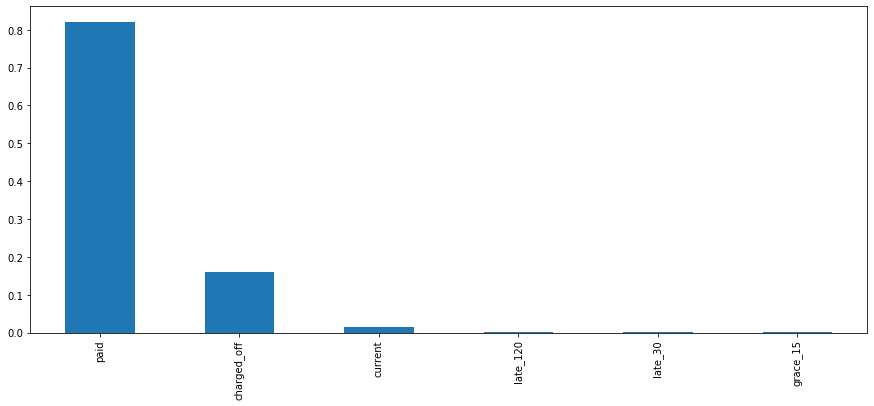

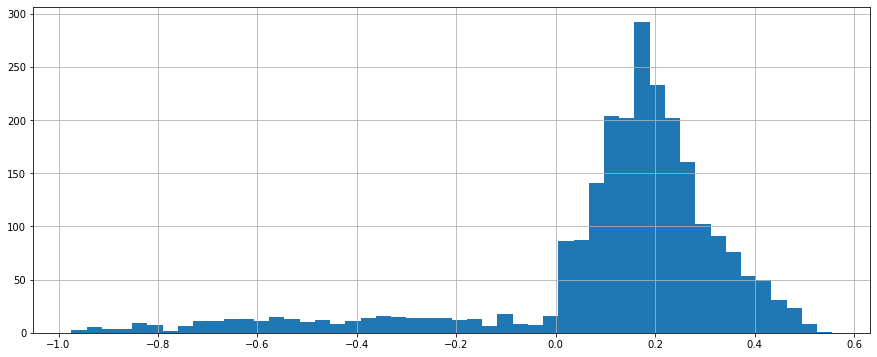

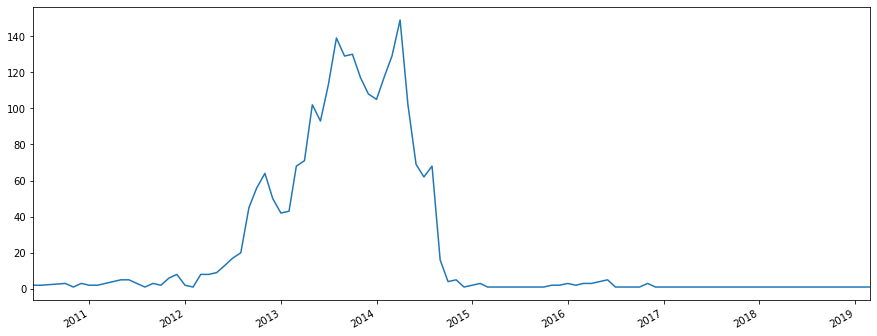

0.03 ________________________


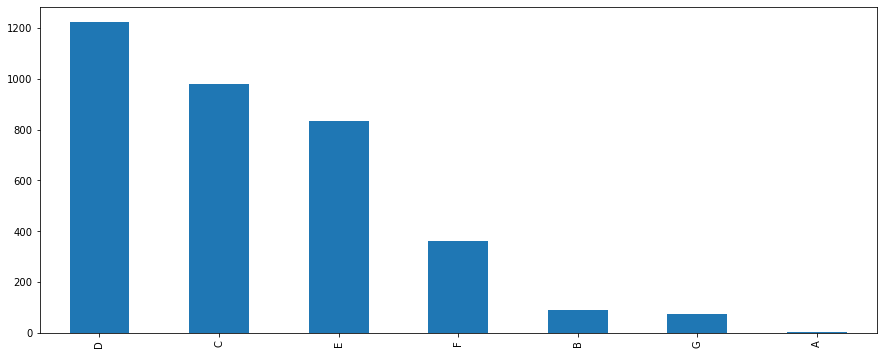

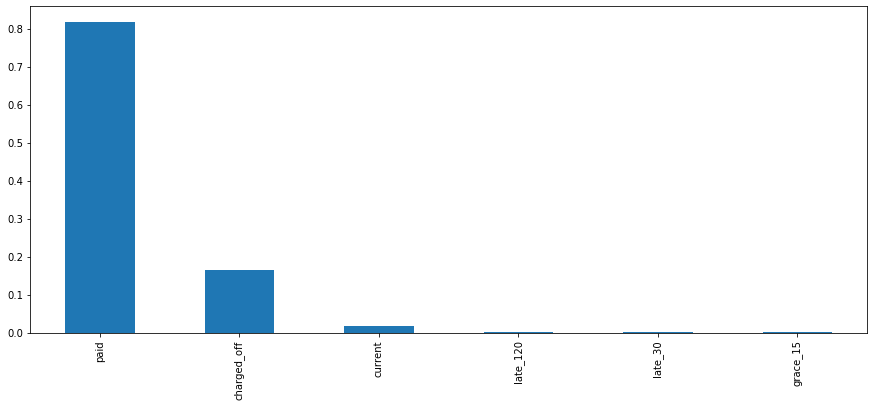

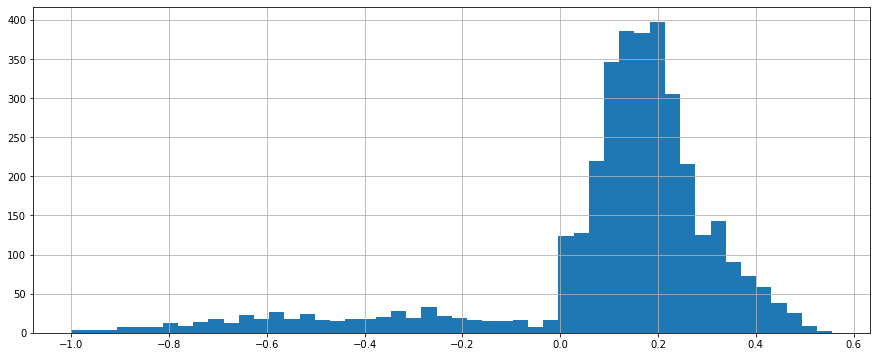

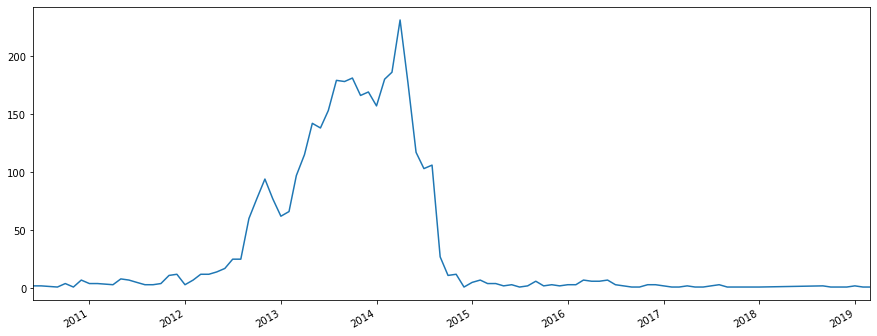

0.05 ________________________


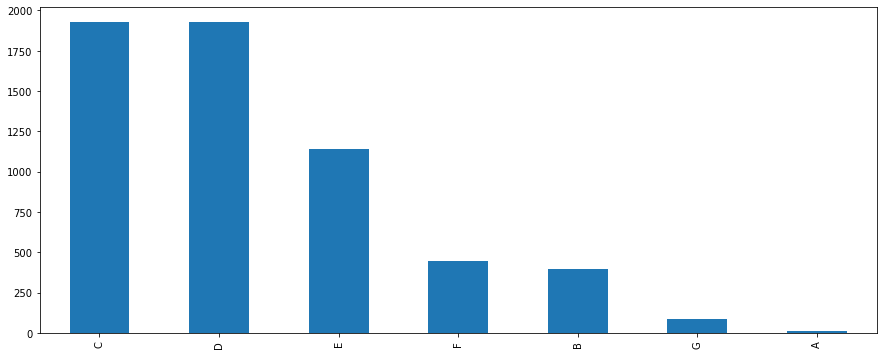

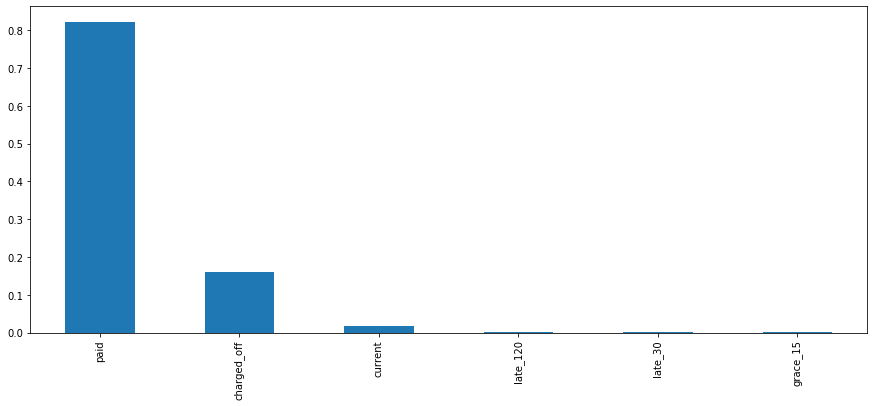

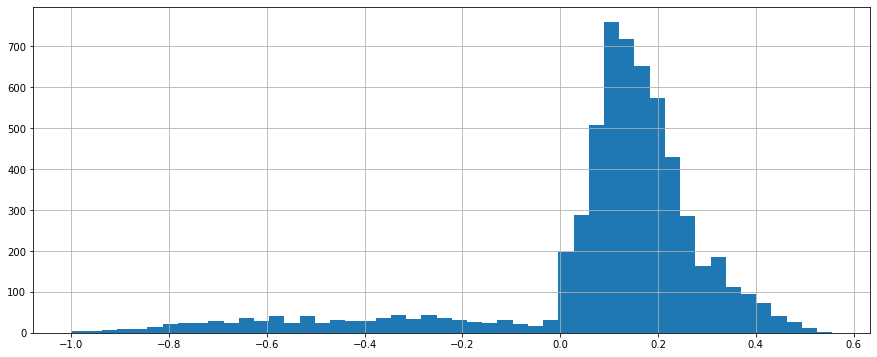

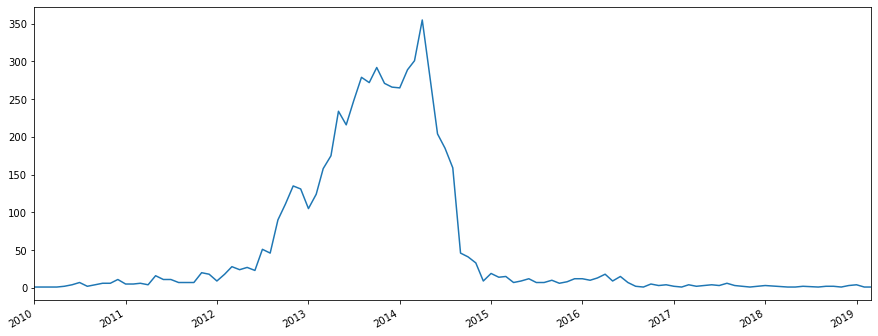

0.1 ________________________


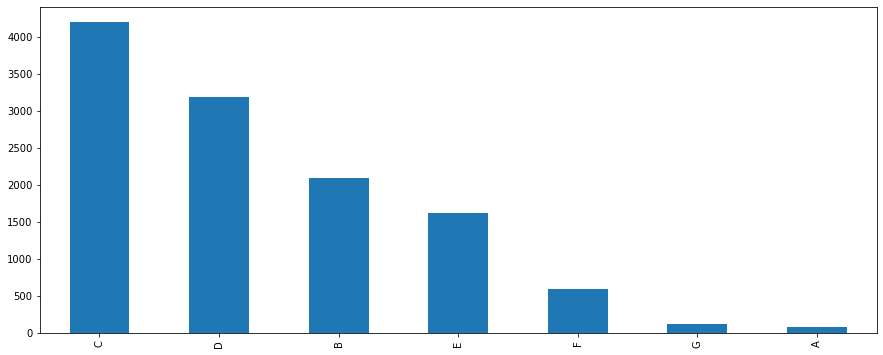

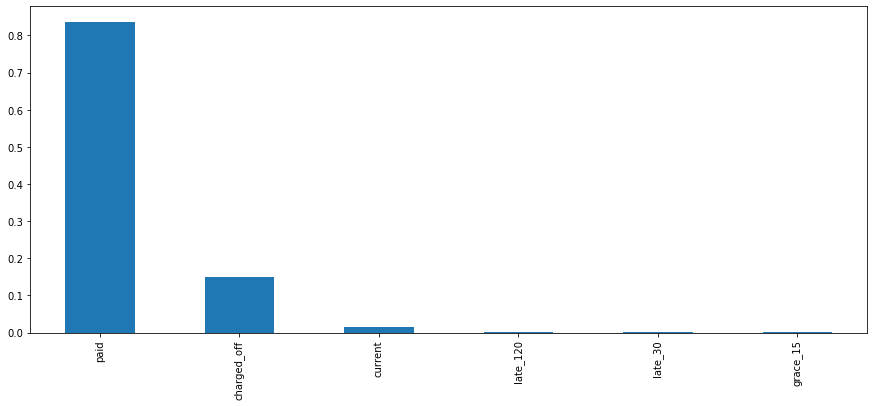

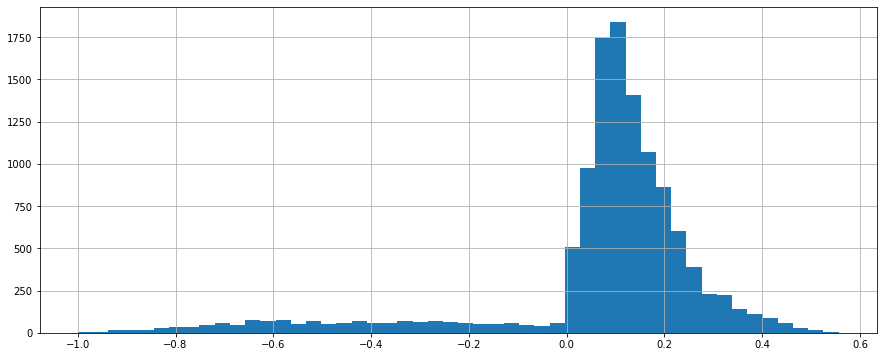

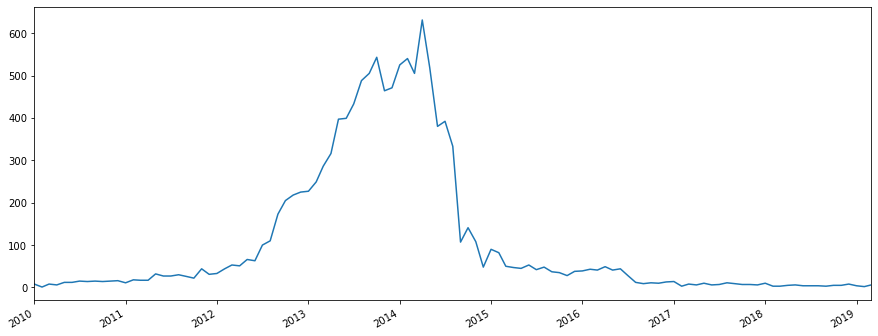

0.15 ________________________


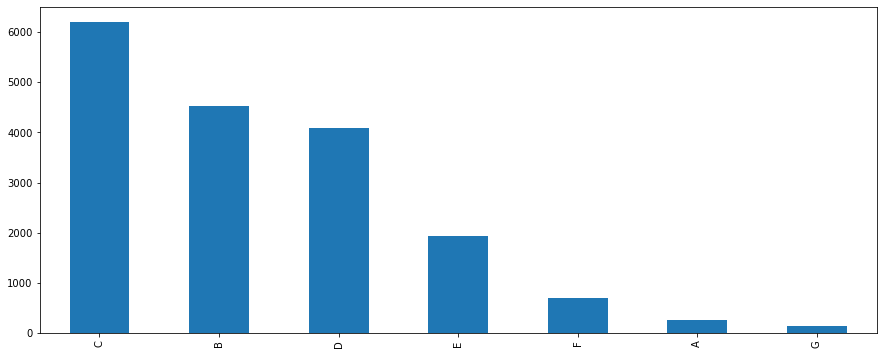

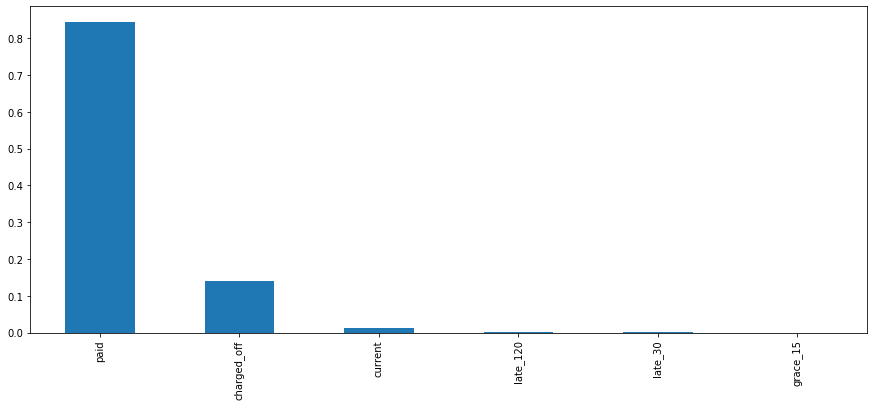

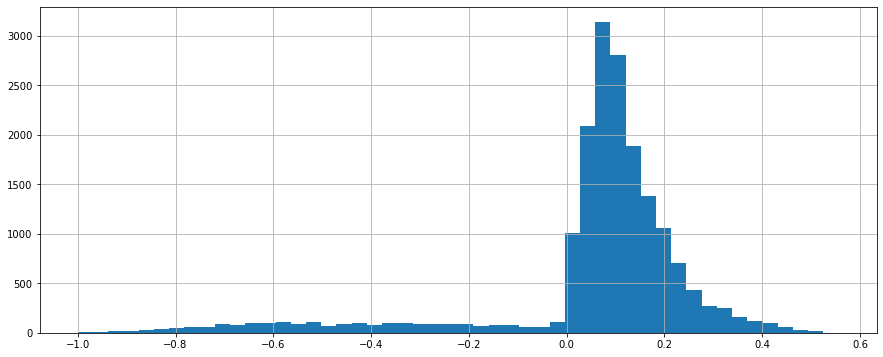

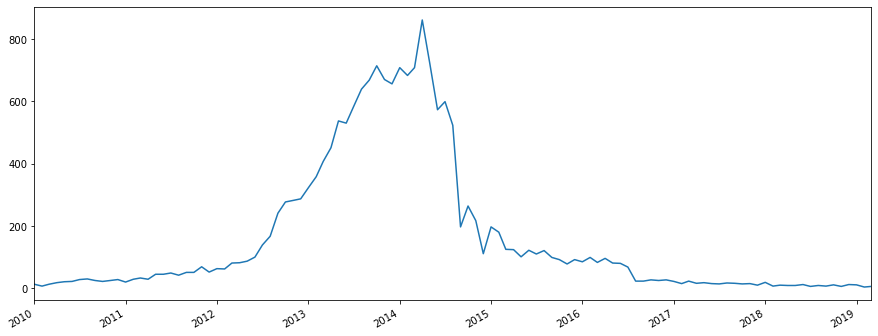

0.2 ________________________


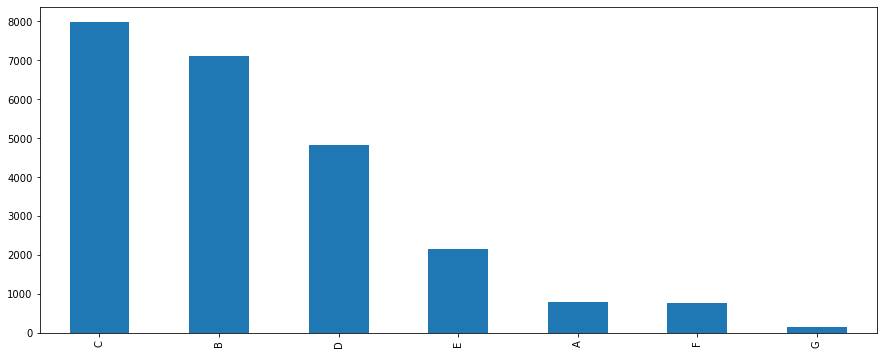

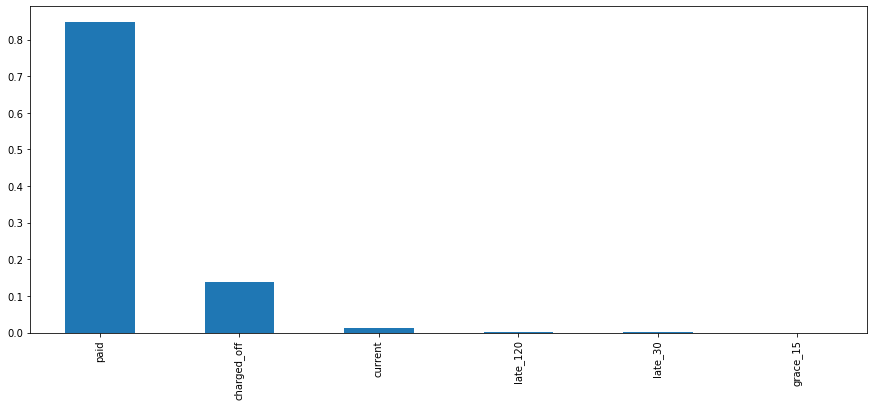

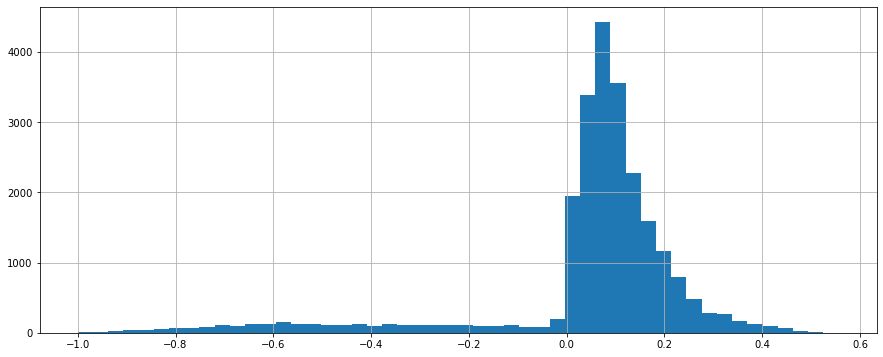

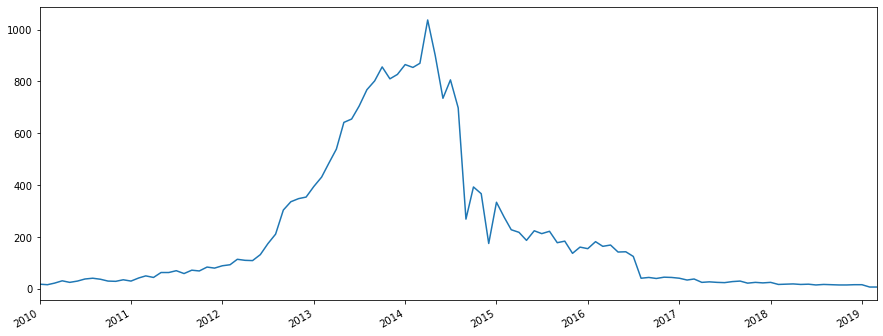

0.3 ________________________


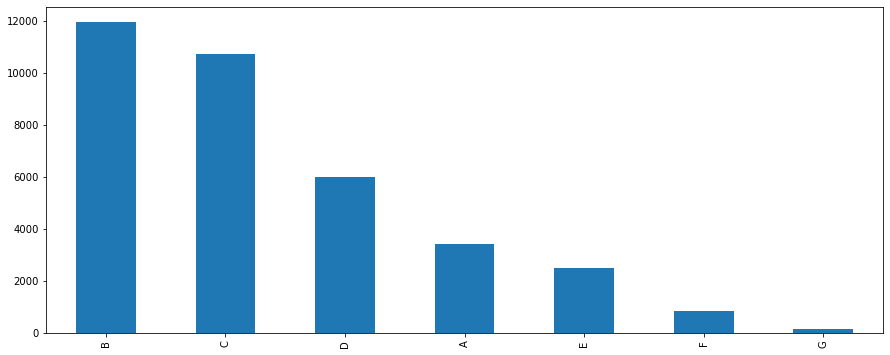

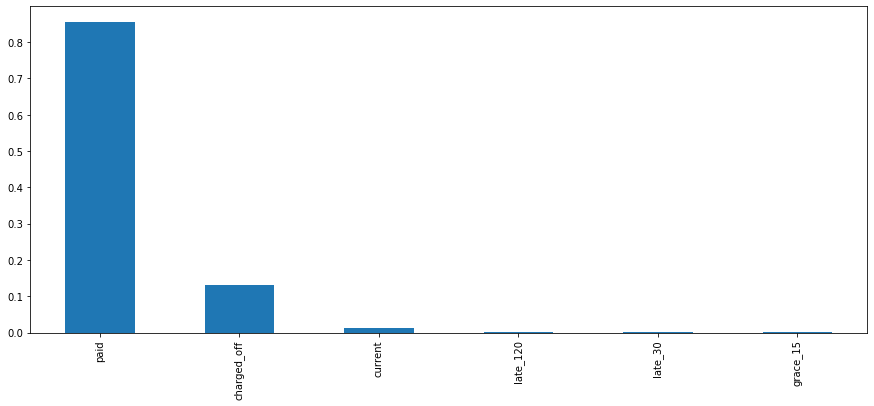

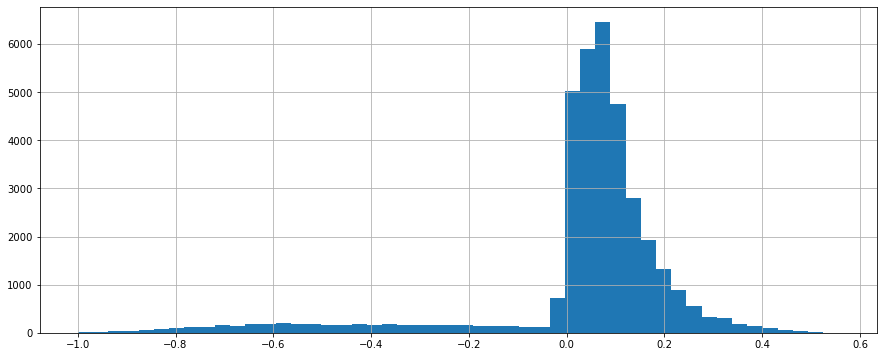

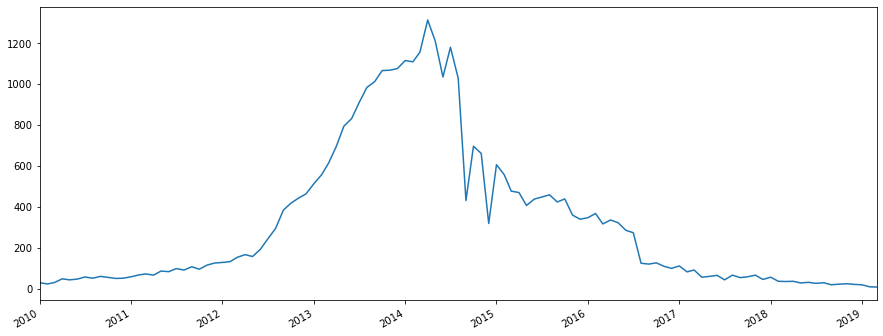

In [124]:
examine_topn_pct('pctl_catboost_regr', top_n)

# Conclusions/Comments

In [126]:
# catboost_clf has learned to pick out A loans (rightly so as they have the lowest probability of default). catboost_regr has learned to pick loans from D/E loans from 2013-2014, as the risk profile compared to return of those loans must have actually been most attractive. 

# Next Steps:
#     Do Model Analysis for clf and regr in catboost (Shap, FI)
#       Result: 
#     Check if I can use catboost built-in nan handling (I think what limits me from this currently is existence of dates in dataframes since catboost needs numeric or string)
#       Result: catboost built-in made no difference in test performance, but made model super bulky. Use
#       Fastai style handling:
#     Want to probably combine the catboost_clf and catboost_regr scores for a composite score; something that will pick safe unless it sees a riskier loan that it wants a lot

# Do these in catboost_modeling and add_score_to_eval_loan_info notebooks

# resave the new dfs

In [86]:
wtn_df.to_csv(os.path.join(dpath, 'whole_topn_df.csv'),)
wtndef_df.to_csv(os.path.join(dpath, 'whole_topn_def_df.csv'),)
mbm_df.to_csv(os.path.join(dpath, 'mbm_topn_df.csv'),)
mbmdef_df.to_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'),)
bsmbm_df.to_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'),)
bsmbmdef_df.to_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'),)

# check saved

In [87]:
wtn_df = pd.read_csv(os.path.join(dpath, 'whole_topn_df.csv'), index_col=0, )
wtndef_df = pd.read_csv(os.path.join(dpath, 'whole_topn_def_df.csv'), index_col=0)
mbm_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_df.csv'), index_col=0, header=[0,1])
mbm_df.index = pd.to_datetime(mbm_df.index)
mbmdef_df = pd.read_csv(os.path.join(dpath, 'mbm_topn_def_df.csv'), index_col=0, header=[0,1])
mbmdef_df.index = pd.to_datetime(mbmdef_df.index)
bsmbm_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_df.csv'), index_col=0, parse_dates=['month'])
bsmbmdef_df = pd.read_csv(os.path.join(dpath, 'bsmbm_topn_def_df.csv'), index_col=0, parse_dates=['month'])

In [88]:
wtn_df

0.01      0.02      0.03      0.05       0.1      0.15  \
catboost_clf  -0.017292 -0.018085 -0.016125 -0.013532 -0.011676 -0.010114   
catboost_regr  0.142223  0.116056  0.102481  0.087108  0.066238  0.053025   
logistic_regr -0.013215 -0.010505 -0.012310 -0.012432 -0.011821 -0.010953   
baseline      -0.048499 -0.047384 -0.047854 -0.052520 -0.052128 -0.053366   
A             -0.025527 -0.032343 -0.031295 -0.031098 -0.030149 -0.030519   
B             -0.027470 -0.027400 -0.031174 -0.034015 -0.032424 -0.033369   
C             -0.059983 -0.055037 -0.058718 -0.059969 -0.055670 -0.055832   
D             -0.076136 -0.075494 -0.077882 -0.075677 -0.074035 -0.071752   
E             -0.078708 -0.087377 -0.078750 -0.082347 -0.058159 -0.033841   
F             -0.100966 -0.091857 -0.066357 -0.043662 -0.015137 -0.001033   
G             -0.081921 -0.038762 -0.029551 -0.020710  0.000762  0.010545   

                    0.2       0.3  
catboost_clf  -0.008317 -0.007211  
catboost_regr  0.043301  0.030283  
logistic_regr -0.009780 -0.011159  
baseline      -0.052360 -0.052550  
A             -0.026094 -0.006938  
B             -0.035116 -0.032662  
C             -0.056341 -0.053168  
D             -0.055487 -0.028161  
E             -0.018750 -0.005292  
F              0.005648  0.008867  
G              0.014452  0.014620

# old

In [219]:
# models = ['baseline', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
# top_n = [.01, .02, .03, .05, .1, .15, .2, .3]
# bs_groups = [idg0, idg1, idg2, idg3, idg4, idg5, idg6, idg7, idg8, idg9]
# issue_d_g = test_eval_loan_info.groupby('issue_d')

# full = {}
# mbm = {}
# bsmbm = {}
# full_def = {}
# mbm_def = {}
# bsmbm_def = {}
# for n in tqdm(top_n):
#     full_h = {}
#     mbm_h = {}
#     bsmbm_h = {}
#     full_def_h = {}
#     mbm_def_h = {}
#     bsmbm_def_h = {}
    
#     for model in models:
#         # get overall top n%
#         full_h[model] = get_topn_ret(model, test_eval_loan_info, n)
#         full_def_h[model] = get_topn_def_pct(model, test_eval_loan_info, n)
        
#         # get month by month
#         temp_mbm = {}
#         temp_mbm_def = {}
#         for d, g in issue_d_g:
#             temp_mbm[d] = get_topn_ret(model, g, n)
#             temp_mbm_def[d] = get_topn_def_pct(model, g, n)
#         mbm_h[model] = temp_mbm
#         mbm_def_h[model] = temp_mbm_def
            
#         # get bsmbm
#         temp_bsmbm = {}
#         temp_bsmbm_def = {}
#         for i, grouper in enumerate(bs_groups):
#             temp = {}
#             temp_def = {}
#             for d, g in grouper:
#                 temp[d] = get_topn_ret(model, g, n)
#                 temp_def[d] = get_topn_def_pct(model, g, n)
#             temp_bsmbm[i] = temp
#             temp_bsmbm_def[i] = temp_def
#         bsmbm_h[model] = temp_bsmbm
#         bsmbm_def_h[model] = temp_bsmbm_def
            
            
#     full[n] = full_h
#     mbm[n] = mbm_h
#     bsmbm[n] = bsmbm_h
#     full_def[n] = full_def_h
#     mbm_def[n] = mbm_def_h
#     bsmbm_def[n] = bsmbm_def_h